# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Sanity Functions

In [2]:
def sanity_check(model, use_softplus=False, transformation_grad=1):

    model_dict = dict(model.state_dict())
    print(model_dict.keys())

    if not use_softplus:
        a = model.transformation.params[transformation_grad].detach().cpu()
        eps = torch.empty_like(a)
        eps[0] = a[0]
        eps[1:] = torch.nn.functional.softplus(a[1:])
        eps = torch.cumsum(eps, dim=0)
    
    is_mono = torch.all(torch.diff(eps) > 0)
    print(is_mono.item())
        
    print(f"{eps}")  # should be strictly increasing
    plt.plot(range(len(eps)), eps, marker='o')
    plt.title("Monotonic spline coefficients ε_j,p")
    plt.xlabel("Basis index p")
    plt.ylabel("ε_j,p")
    plt.show()

def series(x):
    """Return a 1D numpy array from tensor OR list/tuple of (tensors|floats)."""
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    if isinstance(x, (list, tuple)):
        return np.array([t.detach().cpu().item() if torch.is_tensor(t) else float(t) for t in x])
    return np.asarray(x)

#### Hyperparameter choice

In [3]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    #"RW2": {"tau_a": 1e-3, "tau_b": 1e-3},   # A) nearly-flat proper  ← recommended
    "RW2": {"tau_a": 1.1,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}

# Test 1 ndependence copula + standard Gaussian marginals (N(0,1))

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Independent Copula and add Gaussian marginals.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [4]:
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)


# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [5]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/tmp/ipykernel_218382/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_218382/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_218382/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [6]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.indep)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [7]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [12]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_test)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_test)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [13]:
model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 4/1000 [00:00<00:31, 32.08it/s]

current_loss: tensor(1.4540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4188, grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<00:28, 35.00it/s]

current_loss: tensor(1.4188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:00<00:29, 32.81it/s]

current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:00<00:27, 34.80it/s]

current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:00<00:26, 36.60it/s]

current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:01<00:25, 36.89it/s]

current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:01<00:28, 33.65it/s]

current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:01<00:26, 35.65it/s]

current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)


  6%|▋         | 64/1000 [00:01<00:25, 36.04it/s]

current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)


  7%|▋         | 73/1000 [00:02<00:25, 36.82it/s]

current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)


  8%|▊         | 77/1000 [00:02<00:27, 33.40it/s]

current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)


  8%|▊         | 81/1000 [00:02<00:28, 32.68it/s]

current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:02<00:30, 30.00it/s]

current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182,

  9%|▉         | 89/1000 [00:02<00:41, 22.05it/s]

current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182,

  9%|▉         | 90/1000 [00:02<00:29, 30.57it/s]

current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
Early Stop at iteration 90 with minimal loss tensor(1.4182, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [14]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True


output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=32,            # will ramp
                mcmc_sample_val=128,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.0001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.1,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=2000  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:01<05:09,  1.56s/it]

IMPROVED! Congrats
[1/200] train=20650.6719  val_ELPD=-0.0007  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.46  priors/obs: decor≈0 trans≈2.06e+04  tau4=0.592767  rank=20  E_qf_mean≈18.7  E_qf_total≈37.4  tau*E_qf≈22.2  target≈22.2  resid≈-2.06e+04  Δ=-1.10e+03   


  1%|          | 2/200 [00:03<05:07,  1.55s/it]

NOT IMPROVED! Nr. 1
[2/200] train=62.1330  val_ELPD=-0.0007  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.459  priors/obs: decor≈0 trans≈24.1  tau4=0.595424  rank=20  E_qf_mean≈18.6  E_qf_total≈37.3  tau*E_qf≈22.2  target≈22.2  resid≈0.0495  Δ=+2.66e-03   


  2%|▏         | 3/200 [00:04<05:05,  1.55s/it]

NOT IMPROVED! Nr. 2
[3/200] train=63.6461  val_ELPD=-0.0007  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.463  priors/obs: decor≈0 trans≈24.1  tau4=0.59785  rank=20  E_qf_mean≈18.6  E_qf_total≈37.1  tau*E_qf≈22.2  target≈22.2  resid≈0.045  Δ=+2.43e-03   


  2%|▏         | 4/200 [00:06<05:02,  1.55s/it]

NOT IMPROVED! Nr. 3
[4/200] train=64.2740  val_ELPD=-0.0007  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.465  priors/obs: decor≈0 trans≈24  tau4=0.59808  rank=20  E_qf_mean≈18.5  E_qf_total≈37  tau*E_qf≈22.1  target≈22.2  resid≈0.0426  Δ=+2.30e-04   


  2%|▎         | 5/200 [00:07<05:01,  1.54s/it]

NOT IMPROVED! Nr. 4
[5/200] train=61.9515  val_ELPD=-0.0007  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.469  priors/obs: decor≈0 trans≈23.9  tau4=0.598512  rank=20  E_qf_mean≈18.4  E_qf_total≈36.9  tau*E_qf≈22.1  target≈22.2  resid≈0.0794  Δ=+4.31e-04   


  3%|▎         | 6/200 [00:09<04:59,  1.54s/it]

NOT IMPROVED! Nr. 5
[6/200] train=64.2554  val_ELPD=-0.0007  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.47  priors/obs: decor≈0 trans≈23.7  tau4=0.599128  rank=20  E_qf_mean≈18.4  E_qf_total≈36.7  tau*E_qf≈22  target≈22.2  resid≈0.113  Δ=+6.17e-04   


  4%|▎         | 7/200 [00:10<04:58,  1.55s/it]

NOT IMPROVED! Nr. 6
[7/200] train=63.8005  val_ELPD=-0.0007  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0501 σmin=0.0501 σmax=0.0501  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.476  priors/obs: decor≈0 trans≈23.6  tau4=0.599906  rank=20  E_qf_mean≈18.3  E_qf_total≈36.6  tau*E_qf≈21.9  target≈22.2  resid≈0.142  Δ=+7.78e-04   


  4%|▍         | 8/200 [00:12<04:56,  1.54s/it]

NOT IMPROVED! Nr. 7
[8/200] train=61.9093  val_ELPD=-0.0007  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0501 σmin=0.0501 σmax=0.0501  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.482  priors/obs: decor≈0 trans≈23.5  tau4=0.600825  rank=20  E_qf_mean≈18.2  E_qf_total≈36.4  tau*E_qf≈21.9  target≈22.2  resid≈0.167  Δ=+9.19e-04   


  4%|▍         | 9/200 [00:13<04:55,  1.55s/it]

NOT IMPROVED! Nr. 8
[9/200] train=62.9661  val_ELPD=-0.0007  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0502 σmin=0.0502 σmax=0.0502  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.488  priors/obs: decor≈0 trans≈23.4  tau4=0.601877  rank=20  E_qf_mean≈18.2  E_qf_total≈36.3  tau*E_qf≈21.9  target≈22.2  resid≈0.191  Δ=+1.05e-03   


  5%|▌         | 10/200 [00:15<04:53,  1.55s/it]

NOT IMPROVED! Nr. 9
[10/200] train=61.3990  val_ELPD=-0.0007  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0502 σmin=0.0502 σmax=0.0502  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.496  priors/obs: decor≈0 trans≈23.3  tau4=0.603044  rank=20  E_qf_mean≈18.1  E_qf_total≈36.2  tau*E_qf≈21.8  target≈22.2  resid≈0.211  Δ=+1.17e-03   


  6%|▌         | 11/200 [00:17<04:51,  1.54s/it]

NOT IMPROVED! Nr. 10
[11/200] train=62.2206  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0503 σmin=0.0503 σmax=0.0503  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.499  priors/obs: decor≈0 trans≈23.2  tau4=0.604323  rank=20  E_qf_mean≈18  E_qf_total≈36  tau*E_qf≈21.8  target≈22.2  resid≈0.23  Δ=+1.28e-03   


  6%|▌         | 12/200 [00:18<04:50,  1.55s/it]

NOT IMPROVED! Nr. 11
[12/200] train=61.1240  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0503 σmin=0.0503 σmax=0.0503  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.504  priors/obs: decor≈0 trans≈23.1  tau4=0.605628  rank=20  E_qf_mean≈18  E_qf_total≈36  tau*E_qf≈21.8  target≈22.2  resid≈0.235  Δ=+1.31e-03   


  6%|▋         | 13/200 [00:20<04:49,  1.55s/it]

NOT IMPROVED! Nr. 12
[13/200] train=62.0215  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0503 σmin=0.0503 σmax=0.0503  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.511  priors/obs: decor≈0 trans≈23.1  tau4=0.606961  rank=20  E_qf_mean≈17.9  E_qf_total≈35.9  tau*E_qf≈21.8  target≈22.2  resid≈0.239  Δ=+1.33e-03   


  7%|▋         | 14/200 [00:21<04:48,  1.55s/it]

NOT IMPROVED! Nr. 13
[14/200] train=64.3200  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0504 σmin=0.0504 σmax=0.0504  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.512  priors/obs: decor≈0 trans≈23  tau4=0.608325  rank=20  E_qf_mean≈17.9  E_qf_total≈35.8  tau*E_qf≈21.8  target≈22.2  resid≈0.244  Δ=+1.36e-03   


  8%|▊         | 15/200 [00:23<04:46,  1.55s/it]

NOT IMPROVED! Nr. 14
[15/200] train=60.6902  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0504 σmin=0.0504 σmax=0.0504  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.521  priors/obs: decor≈0 trans≈22.9  tau4=0.609709  rank=20  E_qf_mean≈17.8  E_qf_total≈35.7  tau*E_qf≈21.8  target≈22.2  resid≈0.247  Δ=+1.38e-03   


  8%|▊         | 16/200 [00:24<04:46,  1.56s/it]

NOT IMPROVED! Nr. 15
[16/200] train=62.2530  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0505 σmin=0.0505 σmax=0.0505  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.526  priors/obs: decor≈0 trans≈22.9  tau4=0.611118  rank=20  E_qf_mean≈17.8  E_qf_total≈35.6  tau*E_qf≈21.7  target≈22.2  resid≈0.251  Δ=+1.41e-03   


  8%|▊         | 17/200 [00:26<04:44,  1.55s/it]

NOT IMPROVED! Nr. 16
[17/200] train=62.9494  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0505 σmin=0.0505 σmax=0.0505  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.531  priors/obs: decor≈0 trans≈22.8  tau4=0.612554  rank=20  E_qf_mean≈17.7  E_qf_total≈35.5  tau*E_qf≈21.7  target≈22.2  resid≈0.255  Δ=+1.44e-03   


  9%|▉         | 18/200 [00:27<04:42,  1.55s/it]

NOT IMPROVED! Nr. 17
[18/200] train=63.5934  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0505 σmin=0.0505 σmax=0.0505  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.539  priors/obs: decor≈0 trans≈22.7  tau4=0.614012  rank=20  E_qf_mean≈17.7  E_qf_total≈35.4  tau*E_qf≈21.7  target≈22.2  resid≈0.258  Δ=+1.46e-03   


 10%|▉         | 19/200 [00:29<04:40,  1.55s/it]

NOT IMPROVED! Nr. 18
[19/200] train=62.6194  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0506 σmin=0.0506 σmax=0.0506  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.547  priors/obs: decor≈0 trans≈22.7  tau4=0.615492  rank=20  E_qf_mean≈17.7  E_qf_total≈35.3  tau*E_qf≈21.7  target≈22.2  resid≈0.261  Δ=+1.48e-03   


 10%|█         | 20/200 [00:30<04:39,  1.55s/it]

NOT IMPROVED! Nr. 19
[20/200] train=62.8572  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0506 σmin=0.0506 σmax=0.0506  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.55  priors/obs: decor≈0 trans≈22.6  tau4=0.616991  rank=20  E_qf_mean≈17.6  E_qf_total≈35.2  tau*E_qf≈21.7  target≈22.2  resid≈0.264  Δ=+1.50e-03   


 10%|█         | 21/200 [00:32<04:37,  1.55s/it]

NOT IMPROVED! Nr. 20
[21/200] train=61.1236  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0506 σmin=0.0506 σmax=0.0506  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.559  priors/obs: decor≈0 trans≈22.5  tau4=0.618507  rank=20  E_qf_mean≈17.6  E_qf_total≈35.1  tau*E_qf≈21.7  target≈22.2  resid≈0.266  Δ=+1.52e-03   


 11%|█         | 22/200 [00:34<04:35,  1.55s/it]

NOT IMPROVED! Nr. 21
[22/200] train=60.9171  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0506 σmin=0.0506 σmax=0.0506  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.565  priors/obs: decor≈0 trans≈22.5  tau4=0.619996  rank=20  E_qf_mean≈17.5  E_qf_total≈35  tau*E_qf≈21.7  target≈22.2  resid≈0.261  Δ=+1.49e-03   


 12%|█▏        | 23/200 [00:35<04:34,  1.55s/it]

NOT IMPROVED! Nr. 22
[23/200] train=61.4422  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0507 σmin=0.0507 σmax=0.0507  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.57  priors/obs: decor≈0 trans≈22.5  tau4=0.621454  rank=20  E_qf_mean≈17.5  E_qf_total≈35  tau*E_qf≈21.7  target≈22.2  resid≈0.255  Δ=+1.46e-03   


 12%|█▏        | 24/200 [00:37<04:32,  1.55s/it]

NOT IMPROVED! Nr. 23
[24/200] train=60.8990  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0507 σmin=0.0507 σmax=0.0507  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.575  priors/obs: decor≈0 trans≈22.4  tau4=0.622892  rank=20  E_qf_mean≈17.5  E_qf_total≈34.9  tau*E_qf≈21.7  target≈22.2  resid≈0.251  Δ=+1.44e-03   


 12%|█▎        | 25/200 [00:38<04:31,  1.55s/it]

NOT IMPROVED! Nr. 24
[25/200] train=62.8102  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0507 σmin=0.0507 σmax=0.0507  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.577  priors/obs: decor≈0 trans≈22.4  tau4=0.624314  rank=20  E_qf_mean≈17.4  E_qf_total≈34.8  tau*E_qf≈21.8  target≈22.2  resid≈0.248  Δ=+1.42e-03   


 13%|█▎        | 26/200 [00:40<04:29,  1.55s/it]

NOT IMPROVED! Nr. 25
[26/200] train=59.7668  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0507 σmin=0.0507 σmax=0.0507  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.585  priors/obs: decor≈0 trans≈22.3  tau4=0.625712  rank=20  E_qf_mean≈17.4  E_qf_total≈34.8  tau*E_qf≈21.8  target≈22.2  resid≈0.243  Δ=+1.40e-03   


 14%|█▎        | 27/200 [00:41<04:28,  1.55s/it]

NOT IMPROVED! Nr. 26
[27/200] train=61.8370  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0508 σmin=0.0508 σmax=0.0508  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.587  priors/obs: decor≈0 trans≈22.3  tau4=0.627101  rank=20  E_qf_mean≈17.4  E_qf_total≈34.7  tau*E_qf≈21.8  target≈22.2  resid≈0.241  Δ=+1.39e-03   


 14%|█▍        | 28/200 [00:43<04:27,  1.55s/it]

NOT IMPROVED! Nr. 27
[28/200] train=61.5925  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0508 σmin=0.0508 σmax=0.0508  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.593  priors/obs: decor≈0 trans≈22.3  tau4=0.628477  rank=20  E_qf_mean≈17.3  E_qf_total≈34.6  tau*E_qf≈21.8  target≈22.2  resid≈0.238  Δ=+1.38e-03   


 14%|█▍        | 29/200 [00:44<04:25,  1.55s/it]

NOT IMPROVED! Nr. 28
[29/200] train=61.0769  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0508 σmin=0.0508 σmax=0.0508  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.598  priors/obs: decor≈0 trans≈22.2  tau4=0.629846  rank=20  E_qf_mean≈17.3  E_qf_total≈34.6  tau*E_qf≈21.8  target≈22.2  resid≈0.237  Δ=+1.37e-03   


 15%|█▌        | 30/200 [00:46<04:24,  1.55s/it]

NOT IMPROVED! Nr. 29
[30/200] train=61.3198  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.003429999999999999, 0.000343]  σ̄=0.0508 σmin=0.0508 σmax=0.0508  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.605  priors/obs: decor≈0 trans≈22.2  tau4=0.631209  rank=20  E_qf_mean≈17.2  E_qf_total≈34.5  tau*E_qf≈21.8  target≈22.2  resid≈0.235  Δ=+1.36e-03   


 15%|█▌        | 30/200 [00:48<04:32,  1.60s/it]

NOT IMPROVED! Nr. 30
[31/200] train=62.7526  val_ELPD=-0.0008  S_train=32 S_val=128  lr=[0.003429999999999999, 0.000343]  σ̄=0.0508 σmin=0.0508 σmax=0.0508  N=2000 B=2000 B̄≈2000.0  lik/obs≈1.611  priors/obs: decor≈0 trans≈22.1  tau4=0.63257  rank=20  E_qf_mean≈17.2  E_qf_total≈34.4  tau*E_qf≈21.8  target≈22.2  resid≈0.234  Δ=+1.36e-03   
Early stop @ epoch 31: no val improvement for 30 epochs.


In [15]:
print(model_freq.transformation.params[0])
print(model.transformation.params[0])

print(len(model_freq.transformation.params[0]))
print(len(model.transformation.params[0]))


print(model_freq.transformation.params[1])
print(model.transformation.params[1])

print(len(model_freq.transformation.params[1]))
print(len(model.transformation.params[1]))

Parameter containing:
tensor([-10.2165,   1.4610,   1.4610,   1.4610,   1.6454,   2.1759,   2.1149,
          2.0102,   1.7181,   1.6411,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-9.9900,  1.6311,  1.6511,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311], device='cuda:0',
       requires_grad=True)
12
12
Parameter containing:
tensor([-10.1859,   1.4862,   1.4862,   1.4871,   1.6701,   1.9715,   2.2477,
          1.8830,   1.9529,   1.6411,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-9.9900,  1.6311,  1.6511,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311], device='cuda:0',
       requires_grad=True)
12
12


FREQ
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.2165,  -8.5469,  -6.8772,  -5.2075,  -3.3857,  -1.1023,   1.1266,
          3.2625,   5.1456,   6.9639,   8.7821,  10.6002])


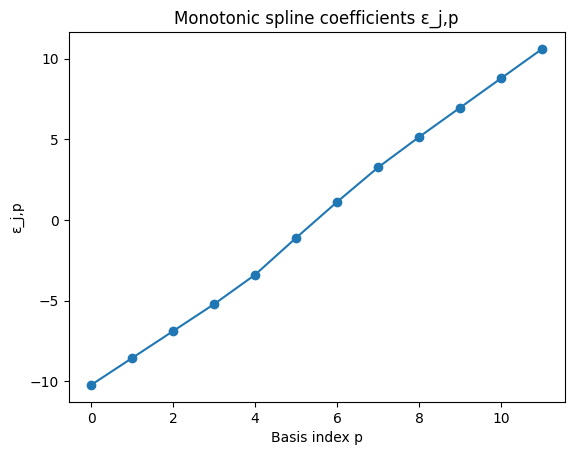

BAY
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9900, -8.1802, -6.3536, -4.5438, -2.7340, -0.9242,  0.8856,  2.6954,
         4.5052,  6.3151,  8.1249,  9.9347])


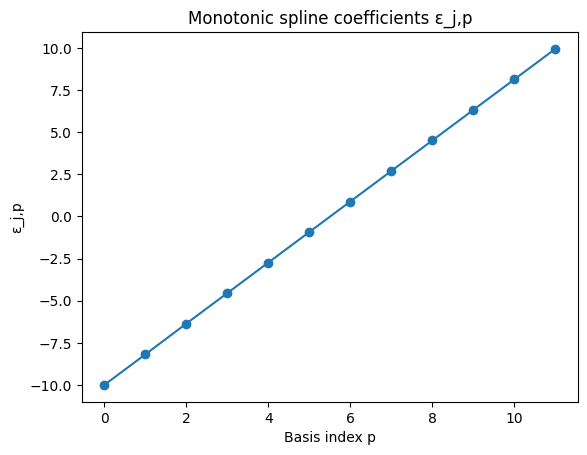

FREQ
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.1859,  -8.4958,  -6.8056,  -5.1148,  -3.2722,  -1.1703,   1.1778,
          3.2024,   5.2880,   7.1062,   8.9243,  10.7425])


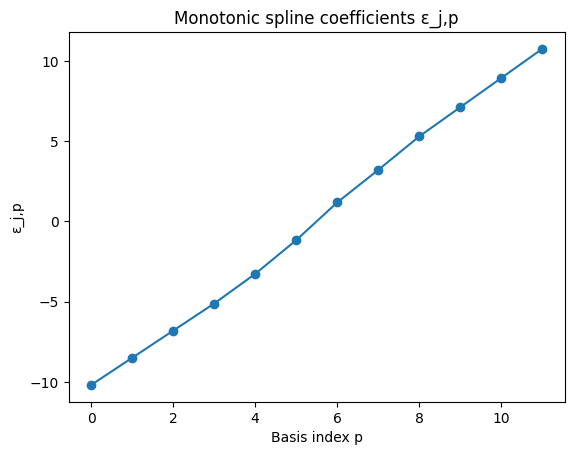

BAY
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9900, -8.1802, -6.3536, -4.5438, -2.7340, -0.9242,  0.8856,  2.6954,
         4.5052,  6.3151,  8.1249,  9.9347])


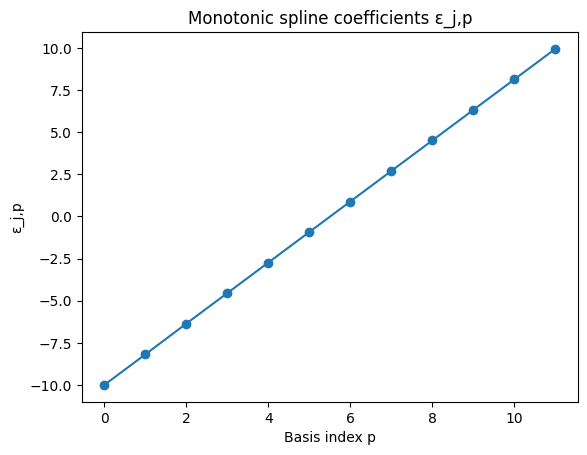

In [16]:
print("FREQ")
sanity_check(model_freq, transformation_grad=0)
print("BAY")
sanity_check(model, transformation_grad=0)
print("FREQ")
sanity_check(model_freq, transformation_grad=1)
print("BAY")
sanity_check(model, transformation_grad=1)

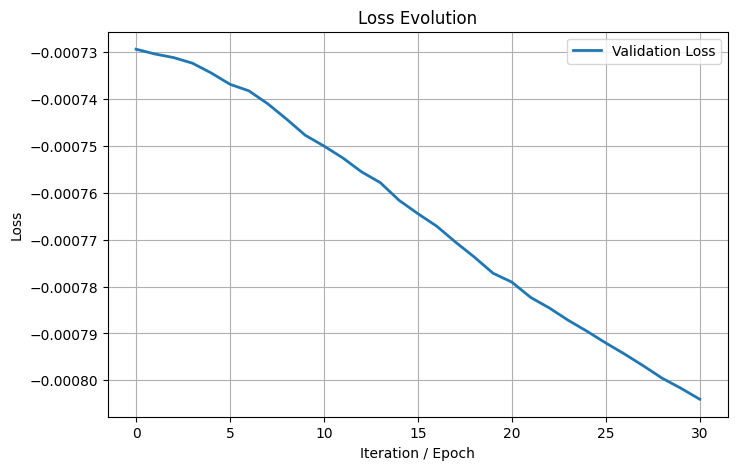

In [17]:
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
print(
    "freq_model nr. parameters", sum(p.numel() for p in model_freq.parameters() if p.requires_grad),
    "bay_model nr. parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))

print("VI Model params = ",output['mu'])
print("BGTM params = ",[p for p in model.parameters() if p.requires_grad])
print("GTMp params = ",[p for p in model_freq.parameters() if p.requires_grad])

freq_model nr. parameters 24 bay_model nr. parameters 24
VI Model params =  tensor([-9.9900,  1.6311,  1.6511,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311, -9.9900,  1.6311,  1.6511,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311],
       device='cuda:0')
BGTM params =  [Parameter containing:
tensor([-9.9900,  1.6311,  1.6511,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([-9.9900,  1.6311,  1.6511,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311], device='cuda:0',
       requires_grad=True)]
GTMp params =  [Parameter containing:
tensor([-10.2165,   1.4610,   1.4610,   1.4610,   1.6454,   2.1759,   2.1149,
          2.0102,   1.7181,   1.6411,   1.6411,   1.6411], requires_grad=True), Parameter containing:
tensor([-10.1859,   1.4862,   1.4862,   1

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [21]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [22]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [23]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0745
KLD GTM      Train Data:  -0.0005
KLD Gaussian Train Data:  -0.0005
KLD Copula   Train Data:  -0.0

KLD BGTM      Test  Data:  0.0772
KLD GTM      Test  Data:  0.0004
KLD Gaussian Test  Data:  0.0006
KLD Copula   Test  Data:  -0.0


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [24]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

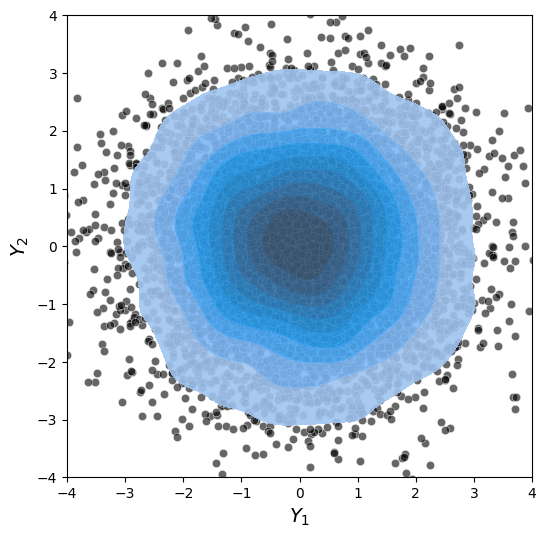

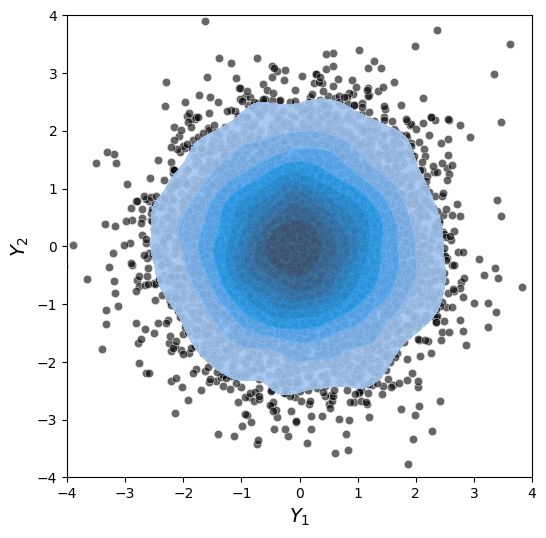

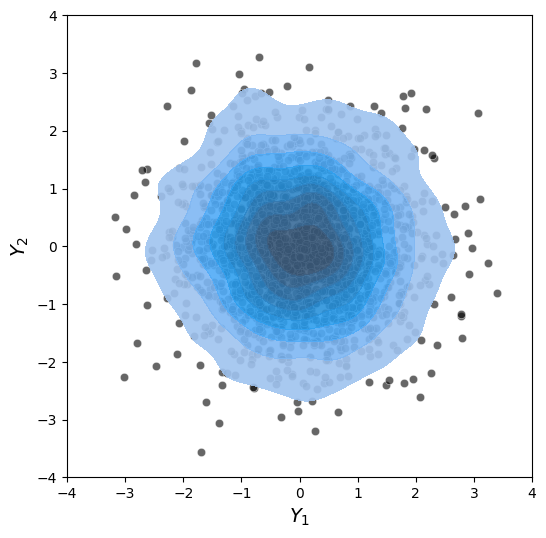

In [25]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

# Test 2
Independence copula + shifted/scaled Gaussian marginals (N(μ, σ²))

In [26]:
# User-chosen marginal parameters
mu = torch.tensor([1.5, -0.7], dtype=torch.float32)
sigma = torch.tensor([1.8, 0.6], dtype=torch.float32)  # stds

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
# Transform uniforms to shifted/scaled Gaussians
Z_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()
simulated_data_train = mu + sigma * Z_train

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
Z_val = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()
simulated_data_validate = mu + sigma * Z_val

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
Z_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()
simulated_data_test = mu + sigma * Z_test

# ---------- "True" log-likelihoods under independence + N(mu, sigma^2) ----------
loglik_true_train = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_train).sum(1)
loglik_true_validate = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_validate).sum(1)
loglik_true_test = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_test).sum(1)

# ---------- "Estimated" marginals from train (fit μ, σ from train) ----------
means = simulated_data_train.mean(0)
stds  = simulated_data_train.std(0, unbiased=True)

loglik_true_est_train = torch.distributions.Normal(means, stds).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means, stds).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means, stds).log_prob(simulated_data_test).sum(1)

In [42]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=300)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=300)

### BGTM model

In [43]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True

output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=32,            # will ramp
                mcmc_sample_val=128,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.5,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=300  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:10<35:34, 10.73s/it]

IMPROVED! Congrats
[1/200] train=20386.4780  val_ELPD=-0.0071  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  lik/obs≈104.5  priors/obs: decor≈0 trans≈2.03e+04  tau4=0.600833  rank=20  E_qf_mean≈18.5  E_qf_total≈36.9  tau*E_qf≈22.2  target≈22.2  resid≈-2.03e+04  Δ=-1.10e+03   


  1%|          | 2/200 [00:21<35:31, 10.76s/it]

IMPROVED! Congrats
[2/200] train=75.4836  val_ELPD=-0.0065  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  lik/obs≈98.02  priors/obs: decor≈0 trans≈23.6  tau4=0.618103  rank=20  E_qf_mean≈18  E_qf_total≈35.9  tau*E_qf≈22.2  target≈22.2  resid≈0.31  Δ=+1.73e-02   


  2%|▏         | 3/200 [00:32<35:10, 10.71s/it]

IMPROVED! Congrats
[3/200] train=74.0344  val_ELPD=-0.0060  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  lik/obs≈89.7  priors/obs: decor≈0 trans≈23.3  tau4=0.628581  rank=20  E_qf_mean≈17.7  E_qf_total≈35.3  tau*E_qf≈22.2  target≈22.2  resid≈0.185  Δ=+1.05e-02   


  2%|▏         | 4/200 [00:42<34:54, 10.68s/it]

IMPROVED! Congrats
[4/200] train=73.1005  val_ELPD=-0.0058  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  lik/obs≈83.76  priors/obs: decor≈0 trans≈22.8  tau4=0.629378  rank=20  E_qf_mean≈17.4  E_qf_total≈34.9  tau*E_qf≈21.9  target≈22.2  resid≈0.139  Δ=+7.97e-04   


  2%|▎         | 5/200 [00:53<34:42, 10.68s/it]

IMPROVED! Congrats
[5/200] train=71.9355  val_ELPD=-0.0057  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  lik/obs≈81.36  priors/obs: decor≈0 trans≈22  tau4=0.631024  rank=20  E_qf_mean≈17.2  E_qf_total≈34.4  tau*E_qf≈21.7  target≈22.2  resid≈0.283  Δ=+1.65e-03   


  3%|▎         | 6/200 [01:04<34:29, 10.66s/it]

NOT IMPROVED! Nr. 1
[6/200] train=70.5945  val_ELPD=-0.0057  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0517 σmin=0.0517 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈81.06  priors/obs: decor≈0 trans≈21.2  tau4=0.633749  rank=20  E_qf_mean≈16.9  E_qf_total≈33.7  tau*E_qf≈21.4  target≈22.2  resid≈0.459  Δ=+2.72e-03   


  4%|▎         | 7/200 [01:14<34:17, 10.66s/it]

IMPROVED! Congrats
[7/200] train=68.6761  val_ELPD=-0.0057  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0535 σmin=0.0535 σmax=0.0535  N=2000 B=200 B̄≈285.7  lik/obs≈80.84  priors/obs: decor≈0 trans≈20.5  tau4=0.637678  rank=20  E_qf_mean≈16.5  E_qf_total≈33  tau*E_qf≈21  target≈22.2  resid≈0.648  Δ=+3.93e-03   


  4%|▍         | 8/200 [01:25<34:06, 10.66s/it]

IMPROVED! Congrats
[8/200] train=67.1780  val_ELPD=-0.0056  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0554 σmin=0.0554 σmax=0.0554  N=2000 B=200 B̄≈285.7  lik/obs≈80.08  priors/obs: decor≈0 trans≈19.9  tau4=0.64284  rank=20  E_qf_mean≈16.1  E_qf_total≈32.2  tau*E_qf≈20.7  target≈22.2  resid≈0.831  Δ=+5.16e-03   


  4%|▍         | 9/200 [01:36<33:55, 10.66s/it]

IMPROVED! Congrats
[9/200] train=65.7330  val_ELPD=-0.0056  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0573 σmin=0.0573 σmax=0.0573  N=2000 B=200 B̄≈285.7  lik/obs≈79.27  priors/obs: decor≈0 trans≈19.3  tau4=0.655578  rank=20  E_qf_mean≈15.7  E_qf_total≈31.4  tau*E_qf≈20.6  target≈22.2  resid≈1  Δ=+1.27e-02   


  5%|▌         | 10/200 [01:46<33:45, 10.66s/it]

IMPROVED! Congrats
[10/200] train=64.4614  val_ELPD=-0.0055  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0593 σmin=0.0593 σmax=0.0593  N=2000 B=200 B̄≈285.7  lik/obs≈78.56  priors/obs: decor≈0 trans≈18.8  tau4=0.66937  rank=20  E_qf_mean≈15.3  E_qf_total≈30.6  tau*E_qf≈20.5  target≈22.2  resid≈1.06  Δ=+1.38e-02   


  6%|▌         | 11/200 [01:57<33:33, 10.66s/it]

IMPROVED! Congrats
[11/200] train=62.3457  val_ELPD=-0.0055  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0613 σmin=0.0613 σmax=0.0613  N=2000 B=200 B̄≈285.7  lik/obs≈78.14  priors/obs: decor≈0 trans≈18.2  tau4=0.684153  rank=20  E_qf_mean≈14.9  E_qf_total≈29.9  tau*E_qf≈20.4  target≈22.2  resid≈1.1  Δ=+1.48e-02   


  6%|▌         | 12/200 [02:08<33:22, 10.65s/it]

IMPROVED! Congrats
[12/200] train=61.6469  val_ELPD=-0.0055  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0634 σmin=0.0634 σmax=0.0634  N=2000 B=200 B̄≈285.7  lik/obs≈77.7  priors/obs: decor≈0 trans≈17.7  tau4=0.699908  rank=20  E_qf_mean≈14.5  E_qf_total≈29.1  tau*E_qf≈20.4  target≈22.2  resid≈1.15  Δ=+1.58e-02   


  6%|▋         | 13/200 [02:18<33:13, 10.66s/it]

IMPROVED! Congrats
[13/200] train=59.9569  val_ELPD=-0.0054  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0656 σmin=0.0656 σmax=0.0656  N=2000 B=200 B̄≈285.7  lik/obs≈77.4  priors/obs: decor≈0 trans≈17.1  tau4=0.716615  rank=20  E_qf_mean≈14.2  E_qf_total≈28.3  tau*E_qf≈20.3  target≈22.2  resid≈1.18  Δ=+1.67e-02   


  7%|▋         | 14/200 [02:29<33:03, 10.67s/it]

IMPROVED! Congrats
[14/200] train=58.6243  val_ELPD=-0.0054  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0679 σmin=0.0678 σmax=0.0679  N=2000 B=200 B̄≈285.7  lik/obs≈77.22  priors/obs: decor≈0 trans≈16.5  tau4=0.734285  rank=20  E_qf_mean≈13.8  E_qf_total≈27.6  tau*E_qf≈20.2  target≈22.2  resid≈1.22  Δ=+1.77e-02   


  8%|▊         | 15/200 [02:40<32:54, 10.67s/it]

IMPROVED! Congrats
[15/200] train=56.6556  val_ELPD=-0.0054  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0702 σmin=0.0702 σmax=0.0702  N=2000 B=200 B̄≈285.7  lik/obs≈77.24  priors/obs: decor≈0 trans≈15.9  tau4=0.752987  rank=20  E_qf_mean≈13.4  E_qf_total≈26.8  tau*E_qf≈20.2  target≈22.2  resid≈1.25  Δ=+1.87e-02   


  8%|▊         | 16/200 [02:50<32:43, 10.67s/it]

NOT IMPROVED! Nr. 1
[16/200] train=55.6560  val_ELPD=-0.0054  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0726 σmin=0.0725 σmax=0.0726  N=2000 B=200 B̄≈285.7  lik/obs≈77.07  priors/obs: decor≈0 trans≈15.2  tau4=0.772768  rank=20  E_qf_mean≈13  E_qf_total≈26.1  tau*E_qf≈20.1  target≈22.2  resid≈1.29  Δ=+1.98e-02   


  8%|▊         | 17/200 [03:01<32:32, 10.67s/it]

NOT IMPROVED! Nr. 2
[17/200] train=54.1857  val_ELPD=-0.0054  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0750 σmin=0.0750 σmax=0.0750  N=2000 B=200 B̄≈285.7  lik/obs≈77  priors/obs: decor≈0 trans≈14.6  tau4=0.793688  rank=20  E_qf_mean≈12.7  E_qf_total≈25.3  tau*E_qf≈20.1  target≈22.2  resid≈1.32  Δ=+2.09e-02   


  9%|▉         | 18/200 [03:12<32:34, 10.74s/it]

IMPROVED! Congrats
[18/200] train=51.9506  val_ELPD=-0.0054  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0775 σmin=0.0775 σmax=0.0776  N=2000 B=200 B̄≈285.7  lik/obs≈76.96  priors/obs: decor≈0 trans≈13.9  tau4=0.815782  rank=20  E_qf_mean≈12.3  E_qf_total≈24.6  tau*E_qf≈20  target≈22.2  resid≈1.36  Δ=+2.21e-02   


 10%|▉         | 19/200 [03:22<32:20, 10.72s/it]

NOT IMPROVED! Nr. 1
[19/200] train=51.1470  val_ELPD=-0.0054  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0801 σmin=0.0801 σmax=0.0802  N=2000 B=200 B̄≈285.7  lik/obs≈76.96  priors/obs: decor≈0 trans≈13.3  tau4=0.839134  rank=20  E_qf_mean≈11.9  E_qf_total≈23.8  tau*E_qf≈20  target≈22.2  resid≈1.39  Δ=+2.34e-02   


 10%|█         | 20/200 [03:33<32:06, 10.70s/it]

NOT IMPROVED! Nr. 2
[20/200] train=49.3178  val_ELPD=-0.0054  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0828 σmin=0.0827 σmax=0.0828  N=2000 B=200 B̄≈285.7  lik/obs≈76.9  priors/obs: decor≈0 trans≈12.6  tau4=0.863724  rank=20  E_qf_mean≈11.5  E_qf_total≈23.1  tau*E_qf≈19.9  target≈22.2  resid≈1.42  Δ=+2.46e-02   


 10%|█         | 21/200 [03:44<31:52, 10.69s/it]

NOT IMPROVED! Nr. 3
[21/200] train=47.8956  val_ELPD=-0.0054  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0855 σmin=0.0854 σmax=0.0856  N=2000 B=200 B̄≈285.7  lik/obs≈77.04  priors/obs: decor≈0 trans≈11.9  tau4=0.889669  rank=20  E_qf_mean≈11.2  E_qf_total≈22.3  tau*E_qf≈19.9  target≈22.2  resid≈1.45  Δ=+2.59e-02   


 11%|█         | 22/200 [03:54<31:40, 10.68s/it]

NOT IMPROVED! Nr. 4
[22/200] train=46.9120  val_ELPD=-0.0054  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0884 σmin=0.0882 σmax=0.0884  N=2000 B=200 B̄≈285.7  lik/obs≈77.21  priors/obs: decor≈0 trans≈11.2  tau4=0.916997  rank=20  E_qf_mean≈10.8  E_qf_total≈21.6  tau*E_qf≈19.8  target≈22.2  resid≈1.48  Δ=+2.73e-02   


 12%|█▏        | 23/200 [04:05<31:27, 10.66s/it]

NOT IMPROVED! Nr. 5
[23/200] train=45.3546  val_ELPD=-0.0054  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0913 σmin=0.0911 σmax=0.0913  N=2000 B=200 B̄≈285.7  lik/obs≈77.27  priors/obs: decor≈0 trans≈10.4  tau4=0.94577  rank=20  E_qf_mean≈10.5  E_qf_total≈20.9  tau*E_qf≈19.8  target≈22.2  resid≈1.51  Δ=+2.88e-02   


 12%|█▏        | 24/200 [04:16<31:15, 10.66s/it]

NOT IMPROVED! Nr. 6
[24/200] train=43.8921  val_ELPD=-0.0054  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0942 σmin=0.0941 σmax=0.0943  N=2000 B=200 B̄≈285.7  lik/obs≈77.4  priors/obs: decor≈0 trans≈9.7  tau4=0.976036  rank=20  E_qf_mean≈10.1  E_qf_total≈20.2  tau*E_qf≈19.7  target≈22.2  resid≈1.53  Δ=+3.03e-02   


 12%|█▎        | 25/200 [04:26<31:03, 10.65s/it]

NOT IMPROVED! Nr. 7
[25/200] train=42.1225  val_ELPD=-0.0054  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0973 σmin=0.0971 σmax=0.0974  N=2000 B=200 B̄≈285.7  lik/obs≈77.53  priors/obs: decor≈0 trans≈8.95  tau4=1.00792  rank=20  E_qf_mean≈9.77  E_qf_total≈19.5  tau*E_qf≈19.7  target≈22.2  resid≈1.56  Δ=+3.19e-02   


 13%|█▎        | 26/200 [04:37<30:51, 10.64s/it]

NOT IMPROVED! Nr. 8
[26/200] train=40.9231  val_ELPD=-0.0055  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.1004 σmin=0.1002 σmax=0.1006  N=2000 B=200 B̄≈285.7  lik/obs≈77.57  priors/obs: decor≈0 trans≈8.18  tau4=1.04157  rank=20  E_qf_mean≈9.44  E_qf_total≈18.9  tau*E_qf≈19.7  target≈22.2  resid≈1.59  Δ=+3.36e-02   


 14%|█▎        | 27/200 [04:48<30:41, 10.65s/it]

NOT IMPROVED! Nr. 9
[27/200] train=39.1470  val_ELPD=-0.0055  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.1036 σmin=0.1034 σmax=0.1038  N=2000 B=200 B̄≈285.7  lik/obs≈77.84  priors/obs: decor≈0 trans≈7.41  tau4=1.0769  rank=20  E_qf_mean≈9.11  E_qf_total≈18.2  tau*E_qf≈19.6  target≈22.2  resid≈1.61  Δ=+3.53e-02   


 14%|█▍        | 28/200 [04:58<30:35, 10.67s/it]

NOT IMPROVED! Nr. 10
[28/200] train=37.6676  val_ELPD=-0.0055  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1070 σmin=0.1067 σmax=0.1071  N=2000 B=200 B̄≈285.7  lik/obs≈78.08  priors/obs: decor≈0 trans≈6.62  tau4=1.1143  rank=20  E_qf_mean≈8.78  E_qf_total≈17.6  tau*E_qf≈19.6  target≈22.2  resid≈1.64  Δ=+3.74e-02   


 14%|█▍        | 29/200 [05:09<30:24, 10.67s/it]

NOT IMPROVED! Nr. 11
[29/200] train=36.4492  val_ELPD=-0.0055  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1093 σmin=0.1090 σmax=0.1095  N=2000 B=200 B̄≈285.7  lik/obs≈78.58  priors/obs: decor≈0 trans≈5.97  tau4=1.15251  rank=20  E_qf_mean≈8.5  E_qf_total≈17  tau*E_qf≈19.6  target≈22.2  resid≈1.62  Δ=+3.82e-02   


 15%|█▌        | 30/200 [05:20<30:12, 10.66s/it]

NOT IMPROVED! Nr. 12
[30/200] train=35.6396  val_ELPD=-0.0055  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1117 σmin=0.1114 σmax=0.1119  N=2000 B=200 B̄≈285.7  lik/obs≈78.77  priors/obs: decor≈0 trans≈5.5  tau4=1.19013  rank=20  E_qf_mean≈8.28  E_qf_total≈16.6  tau*E_qf≈19.7  target≈22.2  resid≈1.56  Δ=+3.76e-02   


 16%|█▌        | 31/200 [05:30<30:04, 10.68s/it]

NOT IMPROVED! Nr. 13
[31/200] train=34.1295  val_ELPD=-0.0055  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1142 σmin=0.1138 σmax=0.1144  N=2000 B=200 B̄≈285.7  lik/obs≈78.93  priors/obs: decor≈0 trans≈5.01  tau4=1.22745  rank=20  E_qf_mean≈8.06  E_qf_total≈16.1  tau*E_qf≈19.8  target≈22.2  resid≈1.5  Δ=+3.73e-02   


 16%|█▌        | 32/200 [05:41<29:55, 10.69s/it]

NOT IMPROVED! Nr. 14
[32/200] train=34.0271  val_ELPD=-0.0056  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1167 σmin=0.1162 σmax=0.1169  N=2000 B=200 B̄≈285.7  lik/obs≈79.03  priors/obs: decor≈0 trans≈4.5  tau4=1.26533  rank=20  E_qf_mean≈7.83  E_qf_total≈15.7  tau*E_qf≈19.8  target≈22.2  resid≈1.48  Δ=+3.79e-02   


 16%|█▋        | 33/200 [05:52<29:42, 10.68s/it]

NOT IMPROVED! Nr. 15
[33/200] train=32.8305  val_ELPD=-0.0056  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1192 σmin=0.1187 σmax=0.1195  N=2000 B=200 B̄≈285.7  lik/obs≈79.32  priors/obs: decor≈0 trans≈3.98  tau4=1.30371  rank=20  E_qf_mean≈7.62  E_qf_total≈15.2  tau*E_qf≈19.9  target≈22.2  resid≈1.46  Δ=+3.84e-02   


 17%|█▋        | 34/200 [06:02<29:30, 10.66s/it]

NOT IMPROVED! Nr. 16
[34/200] train=31.6044  val_ELPD=-0.0056  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1218 σmin=0.1213 σmax=0.1221  N=2000 B=200 B̄≈285.7  lik/obs≈79.57  priors/obs: decor≈0 trans≈3.44  tau4=1.343  rank=20  E_qf_mean≈7.4  E_qf_total≈14.8  tau*E_qf≈19.9  target≈22.2  resid≈1.45  Δ=+3.93e-02   


 18%|█▊        | 35/200 [06:13<29:19, 10.67s/it]

NOT IMPROVED! Nr. 17
[35/200] train=30.5153  val_ELPD=-0.0056  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1244 σmin=0.1238 σmax=0.1247  N=2000 B=200 B̄≈285.7  lik/obs≈80.15  priors/obs: decor≈0 trans≈2.9  tau4=1.38364  rank=20  E_qf_mean≈7.18  E_qf_total≈14.4  tau*E_qf≈19.9  target≈22.2  resid≈1.46  Δ=+4.06e-02   


 18%|█▊        | 36/200 [06:24<29:08, 10.66s/it]

NOT IMPROVED! Nr. 18
[36/200] train=29.7173  val_ELPD=-0.0056  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1270 σmin=0.1264 σmax=0.1274  N=2000 B=200 B̄≈285.7  lik/obs≈80.23  priors/obs: decor≈0 trans≈2.34  tau4=1.42598  rank=20  E_qf_mean≈6.96  E_qf_total≈13.9  tau*E_qf≈19.8  target≈22.2  resid≈1.47  Δ=+4.23e-02   


 18%|█▊        | 37/200 [06:34<28:56, 10.65s/it]

NOT IMPROVED! Nr. 19
[37/200] train=28.7520  val_ELPD=-0.0056  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1298 σmin=0.1291 σmax=0.1302  N=2000 B=200 B̄≈285.7  lik/obs≈80.36  priors/obs: decor≈0 trans≈1.79  tau4=1.47002  rank=20  E_qf_mean≈6.74  E_qf_total≈13.5  tau*E_qf≈19.8  target≈22.2  resid≈1.48  Δ=+4.40e-02   


 19%|█▉        | 38/200 [06:45<28:46, 10.66s/it]

NOT IMPROVED! Nr. 20
[38/200] train=27.7308  val_ELPD=-0.0057  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1325 σmin=0.1318 σmax=0.1330  N=2000 B=200 B̄≈285.7  lik/obs≈80.51  priors/obs: decor≈0 trans≈1.22  tau4=1.51615  rank=20  E_qf_mean≈6.53  E_qf_total≈13.1  tau*E_qf≈19.8  target≈22.2  resid≈1.51  Δ=+4.61e-02   


 20%|█▉        | 39/200 [06:56<28:33, 10.64s/it]

NOT IMPROVED! Nr. 21
[39/200] train=26.4302  val_ELPD=-0.0057  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1345 σmin=0.1337 σmax=0.1350  N=2000 B=200 B̄≈285.7  lik/obs≈81.38  priors/obs: decor≈0 trans≈0.761  tau4=1.56338  rank=20  E_qf_mean≈6.33  E_qf_total≈12.7  tau*E_qf≈19.8  target≈22.2  resid≈1.5  Δ=+4.72e-02   


 20%|██        | 40/200 [07:06<28:21, 10.64s/it]

NOT IMPROVED! Nr. 22
[40/200] train=26.0467  val_ELPD=-0.0057  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1365 σmin=0.1357 σmax=0.1370  N=2000 B=200 B̄≈285.7  lik/obs≈81.13  priors/obs: decor≈0 trans≈0.454  tau4=1.60942  rank=20  E_qf_mean≈6.19  E_qf_total≈12.4  tau*E_qf≈19.9  target≈22.2  resid≈1.42  Δ=+4.60e-02   


 20%|██        | 41/200 [07:17<28:09, 10.63s/it]

NOT IMPROVED! Nr. 23
[41/200] train=25.1526  val_ELPD=-0.0057  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1385 σmin=0.1376 σmax=0.1391  N=2000 B=200 B̄≈285.7  lik/obs≈81.65  priors/obs: decor≈0 trans≈0.122  tau4=1.65511  rank=20  E_qf_mean≈6.04  E_qf_total≈12.1  tau*E_qf≈20  target≈22.2  resid≈1.38  Δ=+4.57e-02   


 21%|██        | 42/200 [07:27<27:57, 10.62s/it]

NOT IMPROVED! Nr. 24
[42/200] train=24.2775  val_ELPD=-0.0057  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1405 σmin=0.1396 σmax=0.1411  N=2000 B=200 B̄≈285.7  lik/obs≈81.88  priors/obs: decor≈0 trans≈-0.222  tau4=1.70087  rank=20  E_qf_mean≈5.89  E_qf_total≈11.8  tau*E_qf≈20  target≈22.2  resid≈1.35  Δ=+4.58e-02   


 22%|██▏       | 43/200 [07:38<27:46, 10.61s/it]

NOT IMPROVED! Nr. 25
[43/200] train=23.9463  val_ELPD=-0.0057  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1426 σmin=0.1416 σmax=0.1432  N=2000 B=200 B̄≈285.7  lik/obs≈82.19  priors/obs: decor≈0 trans≈-0.581  tau4=1.7473  rank=20  E_qf_mean≈5.74  E_qf_total≈11.5  tau*E_qf≈20.1  target≈22.2  resid≈1.33  Δ=+4.64e-02   


 22%|██▏       | 44/200 [07:49<27:35, 10.61s/it]

NOT IMPROVED! Nr. 26
[44/200] train=23.7631  val_ELPD=-0.0058  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1447 σmin=0.1436 σmax=0.1454  N=2000 B=200 B̄≈285.7  lik/obs≈82.54  priors/obs: decor≈0 trans≈-0.953  tau4=1.79494  rank=20  E_qf_mean≈5.59  E_qf_total≈11.2  tau*E_qf≈20.1  target≈22.2  resid≈1.33  Δ=+4.76e-02   


 22%|██▎       | 45/200 [07:59<27:24, 10.61s/it]

NOT IMPROVED! Nr. 27
[45/200] train=22.2576  val_ELPD=-0.0058  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1468 σmin=0.1456 σmax=0.1475  N=2000 B=200 B̄≈285.7  lik/obs≈82.54  priors/obs: decor≈0 trans≈-1.31  tau4=1.84324  rank=20  E_qf_mean≈5.45  E_qf_total≈10.9  tau*E_qf≈20.1  target≈22.2  resid≈1.32  Δ=+4.83e-02   


 23%|██▎       | 46/200 [08:10<27:13, 10.60s/it]

NOT IMPROVED! Nr. 28
[46/200] train=21.6114  val_ELPD=-0.0058  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1489 σmin=0.1476 σmax=0.1497  N=2000 B=200 B̄≈285.7  lik/obs≈83.17  priors/obs: decor≈0 trans≈-1.71  tau4=1.89363  rank=20  E_qf_mean≈5.3  E_qf_total≈10.6  tau*E_qf≈20.1  target≈22.2  resid≈1.33  Δ=+5.04e-02   


 24%|██▎       | 47/200 [08:20<27:01, 10.60s/it]

NOT IMPROVED! Nr. 29
[47/200] train=21.0321  val_ELPD=-0.0058  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1511 σmin=0.1497 σmax=0.1519  N=2000 B=200 B̄≈285.7  lik/obs≈83.33  priors/obs: decor≈0 trans≈-2.09  tau4=1.9459  rank=20  E_qf_mean≈5.15  E_qf_total≈10.3  tau*E_qf≈20  target≈22.2  resid≈1.35  Δ=+5.23e-02   


 24%|██▎       | 47/200 [08:31<27:45, 10.88s/it]

NOT IMPROVED! Nr. 30
[48/200] train=20.2674  val_ELPD=-0.0059  S_train=32 S_val=128  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.1533 σmin=0.1518 σmax=0.1542  N=2000 B=200 B̄≈285.7  lik/obs≈83.04  priors/obs: decor≈0 trans≈-2.47  tau4=1.99973  rank=20  E_qf_mean≈5.01  E_qf_total≈10  tau*E_qf≈20  target≈22.2  resid≈1.35  Δ=+5.38e-02   
Early stop @ epoch 48: no val improvement for 30 epochs.


### GTM model

In [44]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 1/1000 [00:00<02:17,  7.24it/s]

current_loss: tensor(2.2348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5027, grad_fn=<MeanBackward0>)
current_loss: tensor(4.4368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5495, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4739,

  0%|          | 3/1000 [00:00<02:08,  7.75it/s]

current_loss: tensor(1.4704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4396,

  0%|          | 4/1000 [00:00<02:14,  7.41it/s]

current_loss: tensor(1.4562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4536,

  1%|          | 6/1000 [00:00<02:12,  7.48it/s]

current_loss: tensor(1.4893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4289,

  1%|          | 7/1000 [00:00<02:08,  7.75it/s]

current_loss: tensor(1.4531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4639,

  1%|          | 9/1000 [00:01<02:13,  7.45it/s]

current_loss: tensor(1.4265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4962, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4663,

  1%|          | 10/1000 [00:01<02:14,  7.36it/s]

current_loss: tensor(1.4484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4618,

  1%|          | 12/1000 [00:01<02:11,  7.54it/s]

current_loss: tensor(1.4253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4942, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4639,

  1%|▏         | 13/1000 [00:01<02:09,  7.62it/s]

current_loss: tensor(1.4619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4615,

  2%|▏         | 15/1000 [00:02<02:15,  7.27it/s]

current_loss: tensor(1.4217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4942, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4663,

  2%|▏         | 16/1000 [00:02<02:12,  7.44it/s]

current_loss: tensor(1.4457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4618,

  2%|▏         | 18/1000 [00:02<02:10,  7.55it/s]

current_loss: tensor(1.4203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4611,

  2%|▏         | 19/1000 [00:02<02:13,  7.36it/s]

current_loss: tensor(1.4616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4616,

  2%|▏         | 21/1000 [00:02<02:16,  7.16it/s]

current_loss: tensor(1.4212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4613,

  2%|▏         | 22/1000 [00:02<02:15,  7.21it/s]

current_loss: tensor(1.4448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4622,

  2%|▏         | 24/1000 [00:03<02:08,  7.62it/s]

current_loss: tensor(1.4204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4612,

  2%|▎         | 25/1000 [00:03<02:09,  7.53it/s]

current_loss: tensor(1.4431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4463,

  3%|▎         | 27/1000 [00:03<02:08,  7.58it/s]

current_loss: tensor(1.4622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4939,

  3%|▎         | 28/1000 [00:03<02:09,  7.51it/s]

current_loss: tensor(1.4461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4459,

  3%|▎         | 30/1000 [00:04<02:08,  7.58it/s]

current_loss: tensor(1.4628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4925,

  3%|▎         | 31/1000 [00:04<02:11,  7.37it/s]

current_loss: tensor(1.4603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4459,

  3%|▎         | 33/1000 [00:04<02:11,  7.38it/s]

current_loss: tensor(1.4578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4945,

  4%|▎         | 35/1000 [00:04<02:06,  7.61it/s]

current_loss: tensor(1.4458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4790,

  4%|▎         | 36/1000 [00:04<02:10,  7.40it/s]

current_loss: tensor(1.4933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4919,

  4%|▎         | 37/1000 [00:04<02:10,  7.39it/s]

current_loss: tensor(1.4459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4789,

  4%|▍         | 39/1000 [00:05<02:07,  7.52it/s]

current_loss: tensor(1.4521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4406, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4416,

  4%|▍         | 39/1000 [00:05<02:11,  7.28it/s]

current_loss: tensor(1.4785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4139, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4521, grad_fn=<MeanBackward0>)
Early Stop at iteration 39 with minimal loss tensor(1.4562, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0234,  -8.2203,  -6.4172,  -4.6138,  -2.8356,  -1.3589,  -0.1809,
          1.0010,   2.4590,   4.2320,   6.0506,   7.8688])


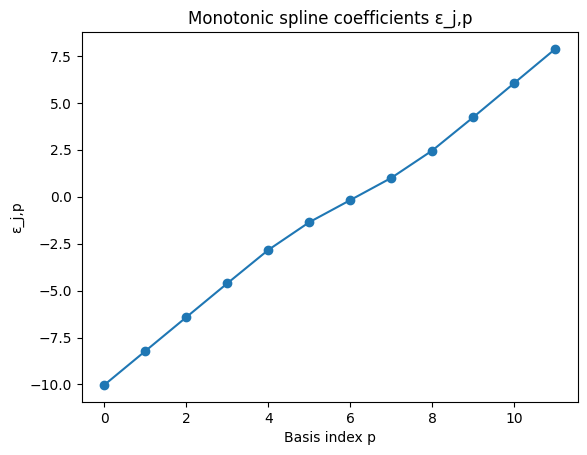

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.1167, -8.0296, -5.9732, -4.4020, -2.9338, -1.5319, -0.2571,  0.8709,
         1.8033,  2.6286,  3.4390,  4.2477])


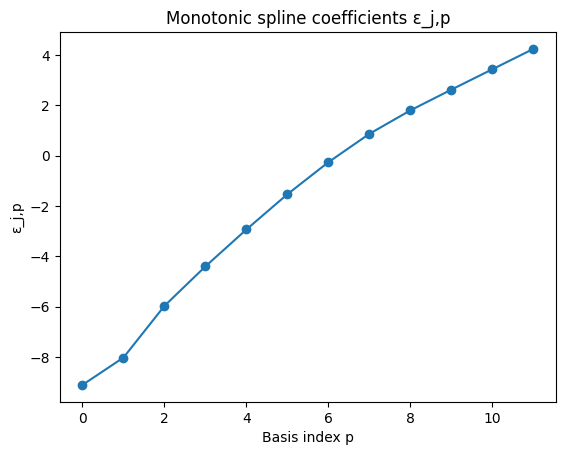

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.2885,  -8.6663,  -7.0441,  -5.4219,  -3.7797,  -0.8404,   3.1265,
          5.1043,   6.9226,   8.7408,  10.5589,  12.3771])


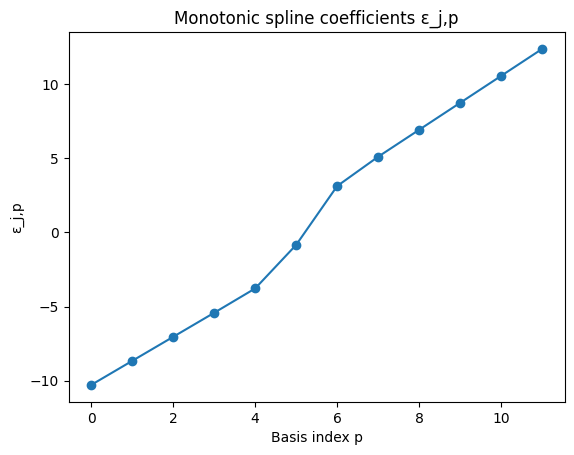

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-8.9113, -7.9379, -5.5905, -4.3843, -3.1971, -0.5759,  2.0577,  2.9550,
         3.7738,  4.5954,  5.4110,  6.2200])


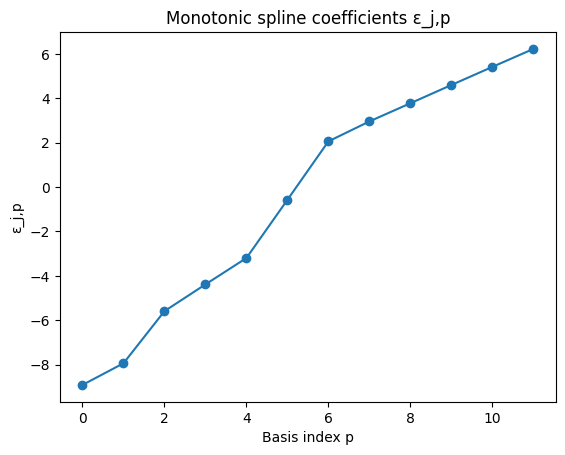

In [45]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

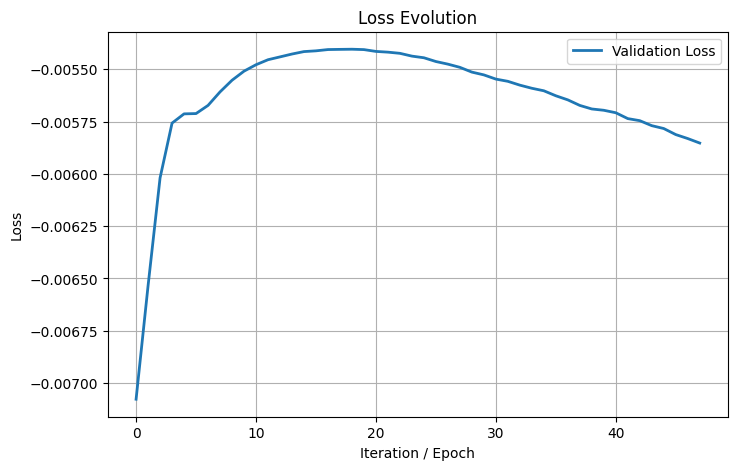

In [46]:
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [48]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [49]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.1473
KLD GTM      Train Data:  0.0091
KLD Gaussian Train Data:  -0.0001
KLD Copula   Train Data:  -0.0001

KLD BGTM      Test  Data:  0.1434
KLD GTM      Test  Data:  0.0119
KLD Gaussian Test  Data:  0.0
KLD Copula   Test  Data:  0.0


In [50]:
#model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1262: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


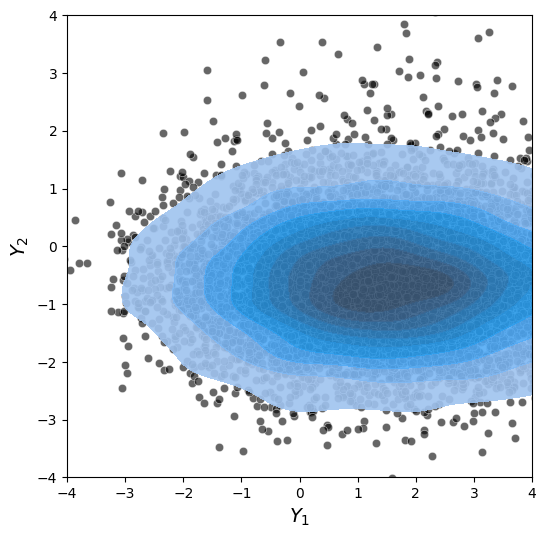

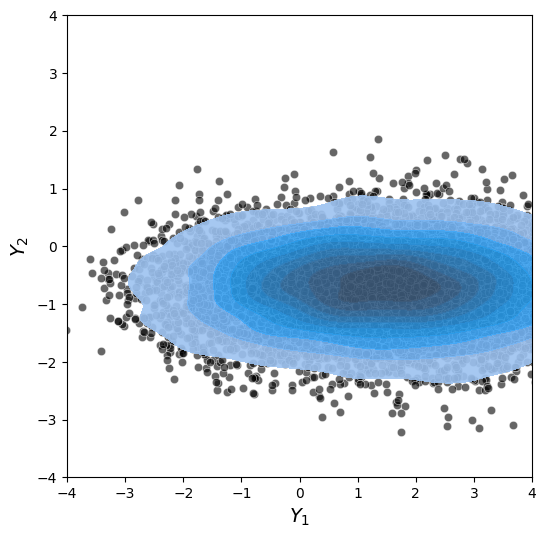

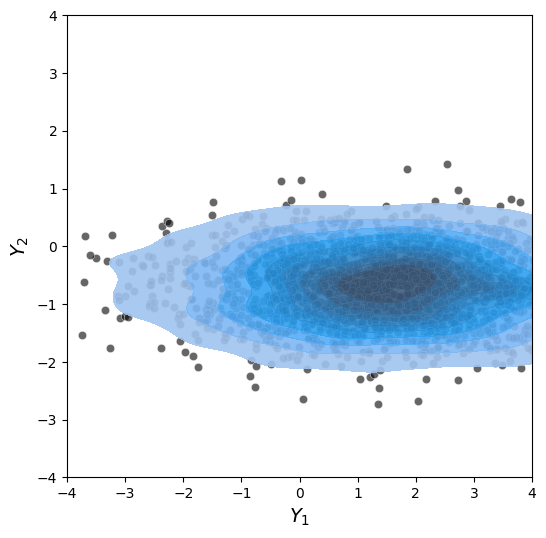

In [51]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

### Independence copula + two-component Gaussian mixture marginals (non-Gaussian)

In [64]:
import numpy as np
import torch
import pyvinecopulib as pv

# Mixture parameters per dimension (same weights across dims for simplicity)
w1 = 0.35  # w2 = 1 - w1
means = torch.tensor([[-2.0,  1.0],   # component 1 means per dim
                      [ 2.0, -1.0]],  # component 2 means per dim
                     dtype=torch.float32)
stds  = torch.tensor([[0.8, 0.5],
                      [0.6, 0.9]], dtype=torch.float32)

def gm2_icdf(u, w1, m, s):
    """
    u: [N, D] tensor in (0,1); w1 scalar; m,s: shape [2, D]
    Returns x: [N, D]
    """
    w2 = 1.0 - w1
    x = torch.empty_like(u)
    mask1 = (u < w1)
    u1 = torch.where(mask1, u / w1, torch.tensor(0.5, dtype=u.dtype))
    u2 = torch.where(~mask1, (u - w1) / w2, torch.tensor(0.5, dtype=u.dtype))
    # invert per dim
    for d in range(u.shape[1]):
        x1 = torch.distributions.Normal(m[0, d], s[0, d]).icdf(u1[:, d])
        x2 = torch.distributions.Normal(m[1, d], s[1, d]).icdf(u2[:, d])
        x[:, d] = torch.where(mask1[:, d], x1, x2)
    return x

def gm2_logpdf(x, w1, m, s):
    w2 = 1.0 - w1
    lp = torch.zeros(x.shape[0])
    for d in range(x.shape[1]):
        lp1 = torch.distributions.Normal(m[0, d], s[0, d]).log_prob(x[:, d])
        lp2 = torch.distributions.Normal(m[1, d], s[1, d]).log_prob(x[:, d])
        # log( w1*e^lp1 + w2*e^lp2 )
        a = torch.stack([lp1 + np.log(w1), lp2 + np.log(w2)], dim=1)
        lp += torch.logsumexp(a, dim=1)
    return lp

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
U_train = torch.tensor(simulated_data_uniform_train).float()
simulated_data_train = gm2_icdf(U_train, w1, means, stds)

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
U_val = torch.tensor(simulated_data_uniform_validate).float()
simulated_data_validate = gm2_icdf(U_val, w1, means, stds)

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
U_test = torch.tensor(simulated_data_uniform_test).float()
simulated_data_test = gm2_icdf(U_test, w1, means, stds)

# ---------- "True" log-likelihoods under independence + GM(2) marginals ----------
loglik_true_train = gm2_logpdf(simulated_data_train, w1, means, stds)
loglik_true_validate = gm2_logpdf(simulated_data_validate, w1, means, stds)
loglik_true_test = gm2_logpdf(simulated_data_test, w1, means, stds)

# ---------- (Optional) crude "estimated" marginals ----------
# For mixtures, proper estimation needs EM or VI. If you just want a baseline,
# you could (very crudely) fit a single Gaussian to each dim:
means_est = simulated_data_train.mean(0)
stds_est  = simulated_data_train.std(0, unbiased=True)
loglik_true_est_train = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_test).sum(1)
# (Use only as a rough reference; your transformation layer should beat this.)


In [65]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=200)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=200)

# BGTM

In [75]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model


output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=32,            # will ramp
                mcmc_sample_val=128,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.000001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.5,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=200  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:15<49:50, 15.03s/it]

IMPROVED! Congrats
[1/200] train=20255.2539  val_ELPD=-0.0103  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈200.0  lik/obs≈211.7  priors/obs: decor≈0 trans≈2.02e+04  tau4=0.604923  rank=20  E_qf_mean≈18.3  E_qf_total≈36.7  tau*E_qf≈22.2  target≈22.2  resid≈-2.02e+04  Δ=-1.10e+03   


  1%|          | 2/200 [00:30<49:31, 15.01s/it]

IMPROVED! Congrats
[2/200] train=81.5025  val_ELPD=-0.0100  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈200.0  lik/obs≈205.8  priors/obs: decor≈0 trans≈23.1  tau4=0.630062  rank=20  E_qf_mean≈17.6  E_qf_total≈35.2  tau*E_qf≈22.2  target≈22.2  resid≈0.443  Δ=+2.51e-02   


  2%|▏         | 3/200 [00:45<49:14, 15.00s/it]

IMPROVED! Congrats
[3/200] train=80.6061  val_ELPD=-0.0099  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈200.0  lik/obs≈199.9  priors/obs: decor≈0 trans≈22.4  tau4=0.647802  rank=20  E_qf_mean≈17.1  E_qf_total≈34.3  tau*E_qf≈22.2  target≈22.2  resid≈0.304  Δ=+1.77e-02   


  2%|▏         | 4/200 [01:00<49:05, 15.03s/it]

IMPROVED! Congrats
[4/200] train=79.0480  val_ELPD=-0.0098  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈200.0  lik/obs≈198.6  priors/obs: decor≈0 trans≈21.5  tau4=0.649874  rank=20  E_qf_mean≈16.6  E_qf_total≈33.2  tau*E_qf≈21.6  target≈22.2  resid≈0.344  Δ=+2.07e-03   


  2%|▎         | 5/200 [01:15<48:55, 15.05s/it]

IMPROVED! Congrats
[5/200] train=77.8934  val_ELPD=-0.0097  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈200.0  lik/obs≈196.8  priors/obs: decor≈0 trans≈20.4  tau4=0.654267  rank=20  E_qf_mean≈16  E_qf_total≈32  tau*E_qf≈20.9  target≈22.2  resid≈0.703  Δ=+4.39e-03   


  3%|▎         | 6/200 [01:30<48:56, 15.13s/it]

IMPROVED! Congrats
[6/200] train=76.3279  val_ELPD=-0.0096  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0525 σmin=0.0525 σmax=0.0525  N=2000 B=200 B̄≈200.0  lik/obs≈194.9  priors/obs: decor≈0 trans≈19.4  tau4=0.667583  rank=20  E_qf_mean≈15.4  E_qf_total≈30.8  tau*E_qf≈20.6  target≈22.2  resid≈1.03  Δ=+1.33e-02   


  4%|▎         | 7/200 [01:45<48:38, 15.12s/it]

IMPROVED! Congrats
[7/200] train=74.1843  val_ELPD=-0.0096  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0551 σmin=0.0551 σmax=0.0551  N=2000 B=200 B̄≈200.0  lik/obs≈193.8  priors/obs: decor≈0 trans≈18.5  tau4=0.683562  rank=20  E_qf_mean≈14.8  E_qf_total≈29.7  tau*E_qf≈20.3  target≈22.2  resid≈1.19  Δ=+1.60e-02   


  4%|▍         | 8/200 [02:00<48:19, 15.10s/it]

IMPROVED! Congrats
[8/200] train=71.7205  val_ELPD=-0.0096  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0579 σmin=0.0579 σmax=0.0579  N=2000 B=200 B̄≈200.0  lik/obs≈193.3  priors/obs: decor≈0 trans≈17.7  tau4=0.701846  rank=20  E_qf_mean≈14.3  E_qf_total≈28.6  tau*E_qf≈20.1  target≈22.2  resid≈1.31  Δ=+1.83e-02   


  4%|▍         | 9/200 [02:15<48:04, 15.10s/it]

IMPROVED! Congrats
[9/200] train=70.2466  val_ELPD=-0.0096  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0608 σmin=0.0607 σmax=0.0608  N=2000 B=200 B̄≈200.0  lik/obs≈192.9  priors/obs: decor≈0 trans≈16.8  tau4=0.722424  rank=20  E_qf_mean≈13.8  E_qf_total≈27.6  tau*E_qf≈19.9  target≈22.2  resid≈1.42  Δ=+2.06e-02   


  5%|▌         | 10/200 [02:30<47:47, 15.09s/it]

IMPROVED! Congrats
[10/200] train=67.9567  val_ELPD=-0.0096  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0638 σmin=0.0638 σmax=0.0638  N=2000 B=200 B̄≈200.0  lik/obs≈192.5  priors/obs: decor≈0 trans≈15.9  tau4=0.7454  rank=20  E_qf_mean≈13.3  E_qf_total≈26.5  tau*E_qf≈19.8  target≈22.2  resid≈1.52  Δ=+2.30e-02   


  6%|▌         | 11/200 [02:45<47:32, 15.09s/it]

IMPROVED! Congrats
[11/200] train=65.5057  val_ELPD=-0.0095  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0669 σmin=0.0669 σmax=0.0669  N=2000 B=200 B̄≈200.0  lik/obs≈192.4  priors/obs: decor≈0 trans≈15.1  tau4=0.770927  rank=20  E_qf_mean≈12.7  E_qf_total≈25.4  tau*E_qf≈19.6  target≈22.2  resid≈1.62  Δ=+2.55e-02   


  6%|▌         | 12/200 [03:00<47:16, 15.09s/it]

NOT IMPROVED! Nr. 1
[12/200] train=63.5593  val_ELPD=-0.0095  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0702 σmin=0.0702 σmax=0.0703  N=2000 B=200 B̄≈200.0  lik/obs≈192.4  priors/obs: decor≈0 trans≈14.1  tau4=0.799159  rank=20  E_qf_mean≈12.2  E_qf_total≈24.3  tau*E_qf≈19.4  target≈22.2  resid≈1.72  Δ=+2.82e-02   


  6%|▋         | 13/200 [03:16<47:00, 15.08s/it]

NOT IMPROVED! Nr. 2
[13/200] train=61.4180  val_ELPD=-0.0096  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0737 σmin=0.0736 σmax=0.0737  N=2000 B=200 B̄≈200.0  lik/obs≈192.6  priors/obs: decor≈0 trans≈13.2  tau4=0.830297  rank=20  E_qf_mean≈11.6  E_qf_total≈23.2  tau*E_qf≈19.3  target≈22.2  resid≈1.81  Δ=+3.11e-02   


  7%|▋         | 14/200 [03:31<46:44, 15.08s/it]

NOT IMPROVED! Nr. 3
[14/200] train=59.6801  val_ELPD=-0.0096  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0773 σmin=0.0772 σmax=0.0773  N=2000 B=200 B̄≈200.0  lik/obs≈192.7  priors/obs: decor≈0 trans≈12.2  tau4=0.864576  rank=20  E_qf_mean≈11.1  E_qf_total≈22.2  tau*E_qf≈19.2  target≈22.2  resid≈1.9  Δ=+3.43e-02   


  8%|▊         | 15/200 [03:46<46:29, 15.08s/it]

NOT IMPROVED! Nr. 4
[15/200] train=57.4046  val_ELPD=-0.0096  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0810 σmin=0.0809 σmax=0.0811  N=2000 B=200 B̄≈200.0  lik/obs≈192.9  priors/obs: decor≈0 trans≈11.3  tau4=0.902237  rank=20  E_qf_mean≈10.5  E_qf_total≈21.1  tau*E_qf≈19  target≈22.2  resid≈1.99  Δ=+3.77e-02   


  8%|▊         | 16/200 [04:01<46:18, 15.10s/it]

NOT IMPROVED! Nr. 5
[16/200] train=55.3372  val_ELPD=-0.0096  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0849 σmin=0.0848 σmax=0.0850  N=2000 B=200 B̄≈200.0  lik/obs≈193.2  priors/obs: decor≈0 trans≈10.2  tau4=0.94356  rank=20  E_qf_mean≈10  E_qf_total≈20  tau*E_qf≈18.9  target≈22.2  resid≈2.07  Δ=+4.13e-02   


  8%|▊         | 17/200 [04:16<46:08, 15.13s/it]

NOT IMPROVED! Nr. 6
[17/200] train=53.2104  val_ELPD=-0.0096  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0890 σmin=0.0888 σmax=0.0891  N=2000 B=200 B̄≈200.0  lik/obs≈193.5  priors/obs: decor≈0 trans≈9.19  tau4=0.988815  rank=20  E_qf_mean≈9.49  E_qf_total≈19  tau*E_qf≈18.8  target≈22.2  resid≈2.15  Δ=+4.53e-02   


  9%|▉         | 18/200 [04:31<45:55, 15.14s/it]

NOT IMPROVED! Nr. 7
[18/200] train=51.0554  val_ELPD=-0.0096  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0932 σmin=0.0930 σmax=0.0933  N=2000 B=200 B̄≈200.0  lik/obs≈193.8  priors/obs: decor≈0 trans≈8.11  tau4=1.03842  rank=20  E_qf_mean≈8.97  E_qf_total≈17.9  tau*E_qf≈18.6  target≈22.2  resid≈2.23  Δ=+4.96e-02   


 10%|▉         | 19/200 [04:46<45:42, 15.15s/it]

NOT IMPROVED! Nr. 8
[19/200] train=48.5912  val_ELPD=-0.0096  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0976 σmin=0.0973 σmax=0.0977  N=2000 B=200 B̄≈200.0  lik/obs≈194  priors/obs: decor≈0 trans≈7.01  tau4=1.09267  rank=20  E_qf_mean≈8.47  E_qf_total≈16.9  tau*E_qf≈18.5  target≈22.2  resid≈2.3  Δ=+5.43e-02   


 10%|█         | 20/200 [05:02<45:28, 15.16s/it]

NOT IMPROVED! Nr. 9
[20/200] train=46.7086  val_ELPD=-0.0097  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1021 σmin=0.1018 σmax=0.1023  N=2000 B=200 B̄≈200.0  lik/obs≈194.5  priors/obs: decor≈0 trans≈5.89  tau4=1.1521  rank=20  E_qf_mean≈7.99  E_qf_total≈16  tau*E_qf≈18.4  target≈22.2  resid≈2.37  Δ=+5.94e-02   


 10%|█         | 21/200 [05:17<45:13, 15.16s/it]

NOT IMPROVED! Nr. 10
[21/200] train=44.6922  val_ELPD=-0.0097  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1054 σmin=0.1050 σmax=0.1056  N=2000 B=200 B̄≈200.0  lik/obs≈195.5  priors/obs: decor≈0 trans≈4.96  tau4=1.21456  rank=20  E_qf_mean≈7.58  E_qf_total≈15.2  tau*E_qf≈18.4  target≈22.2  resid≈2.37  Δ=+6.25e-02   


 11%|█         | 22/200 [05:32<44:58, 15.16s/it]

NOT IMPROVED! Nr. 11
[22/200] train=43.2282  val_ELPD=-0.0097  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1088 σmin=0.1083 σmax=0.1090  N=2000 B=200 B̄≈200.0  lik/obs≈195.7  priors/obs: decor≈0 trans≈4.28  tau4=1.27747  rank=20  E_qf_mean≈7.26  E_qf_total≈14.5  tau*E_qf≈18.5  target≈22.2  resid≈2.28  Δ=+6.29e-02   


 12%|█▏        | 23/200 [05:47<44:44, 15.17s/it]

NOT IMPROVED! Nr. 12
[23/200] train=41.8589  val_ELPD=-0.0097  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1122 σmin=0.1117 σmax=0.1125  N=2000 B=200 B̄≈200.0  lik/obs≈196.1  priors/obs: decor≈0 trans≈3.55  tau4=1.34197  rank=20  E_qf_mean≈6.94  E_qf_total≈13.9  tau*E_qf≈18.6  target≈22.2  resid≈2.24  Δ=+6.45e-02   


 12%|█▏        | 24/200 [06:02<44:30, 15.17s/it]

NOT IMPROVED! Nr. 13
[24/200] train=40.7417  val_ELPD=-0.0098  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1157 σmin=0.1151 σmax=0.1161  N=2000 B=200 B̄≈200.0  lik/obs≈197  priors/obs: decor≈0 trans≈2.8  tau4=1.40846  rank=20  E_qf_mean≈6.63  E_qf_total≈13.3  tau*E_qf≈18.7  target≈22.2  resid≈2.2  Δ=+6.65e-02   


 12%|█▎        | 25/200 [06:17<44:13, 15.16s/it]

NOT IMPROVED! Nr. 14
[25/200] train=39.5516  val_ELPD=-0.0098  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1194 σmin=0.1187 σmax=0.1198  N=2000 B=200 B̄≈200.0  lik/obs≈197.5  priors/obs: decor≈0 trans≈2.02  tau4=1.47798  rank=20  E_qf_mean≈6.32  E_qf_total≈12.6  tau*E_qf≈18.7  target≈22.2  resid≈2.2  Δ=+6.95e-02   


 13%|█▎        | 26/200 [06:33<44:03, 15.20s/it]

NOT IMPROVED! Nr. 15
[26/200] train=37.7256  val_ELPD=-0.0098  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1231 σmin=0.1223 σmax=0.1235  N=2000 B=200 B̄≈200.0  lik/obs≈198.4  priors/obs: decor≈0 trans≈1.23  tau4=1.55065  rank=20  E_qf_mean≈6.03  E_qf_total≈12.1  tau*E_qf≈18.7  target≈22.2  resid≈2.19  Δ=+7.27e-02   


 14%|█▎        | 27/200 [06:48<43:42, 15.16s/it]

NOT IMPROVED! Nr. 16
[27/200] train=36.1026  val_ELPD=-0.0099  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1269 σmin=0.1261 σmax=0.1274  N=2000 B=200 B̄≈200.0  lik/obs≈199.2  priors/obs: decor≈0 trans≈0.427  tau4=1.62679  rank=20  E_qf_mean≈5.75  E_qf_total≈11.5  tau*E_qf≈18.7  target≈22.2  resid≈2.19  Δ=+7.61e-02   


 14%|█▍        | 28/200 [07:03<43:22, 15.13s/it]

NOT IMPROVED! Nr. 17
[28/200] train=34.4173  val_ELPD=-0.0099  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1308 σmin=0.1298 σmax=0.1314  N=2000 B=200 B̄≈200.0  lik/obs≈200.1  priors/obs: decor≈0 trans≈-0.386  tau4=1.70681  rank=20  E_qf_mean≈5.48  E_qf_total≈11  tau*E_qf≈18.7  target≈22.2  resid≈2.19  Δ=+8.00e-02   


 14%|█▍        | 29/200 [07:18<43:04, 15.11s/it]

NOT IMPROVED! Nr. 18
[29/200] train=33.1916  val_ELPD=-0.0100  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1348 σmin=0.1337 σmax=0.1355  N=2000 B=200 B̄≈200.0  lik/obs≈201.1  priors/obs: decor≈0 trans≈-1.21  tau4=1.79144  rank=20  E_qf_mean≈5.21  E_qf_total≈10.4  tau*E_qf≈18.7  target≈22.2  resid≈2.21  Δ=+8.46e-02   


 15%|█▌        | 30/200 [07:33<42:48, 15.11s/it]

NOT IMPROVED! Nr. 19
[30/200] train=31.8905  val_ELPD=-0.0100  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1389 σmin=0.1376 σmax=0.1398  N=2000 B=200 B̄≈200.0  lik/obs≈202.2  priors/obs: decor≈0 trans≈-2.04  tau4=1.88072  rank=20  E_qf_mean≈4.96  E_qf_total≈9.92  tau*E_qf≈18.7  target≈22.2  resid≈2.21  Δ=+8.93e-02   


 16%|█▌        | 31/200 [07:48<42:31, 15.10s/it]

NOT IMPROVED! Nr. 20
[31/200] train=31.2310  val_ELPD=-0.0101  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1419 σmin=0.1404 σmax=0.1428  N=2000 B=200 B̄≈200.0  lik/obs≈203.4  priors/obs: decor≈0 trans≈-2.71  tau4=1.97217  rank=20  E_qf_mean≈4.75  E_qf_total≈9.49  tau*E_qf≈18.7  target≈22.2  resid≈2.17  Δ=+9.15e-02   


 16%|█▌        | 32/200 [08:03<42:15, 15.09s/it]

NOT IMPROVED! Nr. 21
[32/200] train=29.4250  val_ELPD=-0.0101  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1449 σmin=0.1433 σmax=0.1459  N=2000 B=200 B̄≈200.0  lik/obs≈203.8  priors/obs: decor≈0 trans≈-3.16  tau4=2.06089  rank=20  E_qf_mean≈4.59  E_qf_total≈9.19  tau*E_qf≈18.9  target≈22.2  resid≈2.04  Δ=+8.87e-02   


 16%|█▋        | 33/200 [08:18<41:59, 15.09s/it]

NOT IMPROVED! Nr. 22
[33/200] train=28.6194  val_ELPD=-0.0102  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1480 σmin=0.1462 σmax=0.1491  N=2000 B=200 B̄≈200.0  lik/obs≈204.8  priors/obs: decor≈0 trans≈-3.67  tau4=2.14962  rank=20  E_qf_mean≈4.43  E_qf_total≈8.86  tau*E_qf≈19  target≈22.2  resid≈1.97  Δ=+8.87e-02   


 17%|█▋        | 34/200 [08:33<41:43, 15.08s/it]

NOT IMPROVED! Nr. 23
[34/200] train=27.6443  val_ELPD=-0.0102  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1511 σmin=0.1492 σmax=0.1523  N=2000 B=200 B̄≈200.0  lik/obs≈205.4  priors/obs: decor≈0 trans≈-4.19  tau4=2.23843  rank=20  E_qf_mean≈4.28  E_qf_total≈8.56  tau*E_qf≈19.2  target≈22.2  resid≈1.9  Δ=+8.88e-02   


 18%|█▊        | 35/200 [08:48<41:26, 15.07s/it]

NOT IMPROVED! Nr. 24
[35/200] train=26.8202  val_ELPD=-0.0103  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1543 σmin=0.1523 σmax=0.1556  N=2000 B=200 B̄≈200.0  lik/obs≈206.5  priors/obs: decor≈0 trans≈-4.73  tau4=2.32889  rank=20  E_qf_mean≈4.12  E_qf_total≈8.25  tau*E_qf≈19.2  target≈22.2  resid≈1.87  Δ=+9.05e-02   


 18%|█▊        | 36/200 [09:03<41:12, 15.07s/it]

NOT IMPROVED! Nr. 25
[36/200] train=25.8413  val_ELPD=-0.0103  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1576 σmin=0.1554 σmax=0.1590  N=2000 B=200 B̄≈200.0  lik/obs≈207.7  priors/obs: decor≈0 trans≈-5.31  tau4=2.4228  rank=20  E_qf_mean≈3.97  E_qf_total≈7.93  tau*E_qf≈19.2  target≈22.2  resid≈1.86  Δ=+9.39e-02   


 18%|█▊        | 37/200 [09:18<40:57, 15.08s/it]

NOT IMPROVED! Nr. 26
[37/200] train=25.3160  val_ELPD=-0.0104  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1609 σmin=0.1585 σmax=0.1625  N=2000 B=200 B̄≈200.0  lik/obs≈208.2  priors/obs: decor≈0 trans≈-5.84  tau4=2.51729  rank=20  E_qf_mean≈3.83  E_qf_total≈7.67  tau*E_qf≈19.3  target≈22.2  resid≈1.81  Δ=+9.45e-02   


 19%|█▉        | 38/200 [09:34<40:45, 15.10s/it]

NOT IMPROVED! Nr. 27
[38/200] train=24.0893  val_ELPD=-0.0104  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1643 σmin=0.1617 σmax=0.1660  N=2000 B=200 B̄≈200.0  lik/obs≈209.8  priors/obs: decor≈0 trans≈-6.41  tau4=2.61439  rank=20  E_qf_mean≈3.7  E_qf_total≈7.39  tau*E_qf≈19.3  target≈22.2  resid≈1.79  Δ=+9.71e-02   


 20%|█▉        | 39/200 [09:49<40:31, 15.10s/it]

NOT IMPROVED! Nr. 28
[39/200] train=23.3413  val_ELPD=-0.0105  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1678 σmin=0.1649 σmax=0.1696  N=2000 B=200 B̄≈200.0  lik/obs≈211.4  priors/obs: decor≈0 trans≈-6.96  tau4=2.71298  rank=20  E_qf_mean≈3.57  E_qf_total≈7.14  tau*E_qf≈19.4  target≈22.2  resid≈1.76  Δ=+9.86e-02   


 20%|██        | 40/200 [10:04<40:15, 15.10s/it]

NOT IMPROVED! Nr. 29
[40/200] train=21.7703  val_ELPD=-0.0105  S_train=32 S_val=128  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.1713 σmin=0.1681 σmax=0.1734  N=2000 B=200 B̄≈200.0  lik/obs≈212.7  priors/obs: decor≈0 trans≈-7.52  tau4=2.81312  rank=20  E_qf_mean≈3.45  E_qf_total≈6.91  tau*E_qf≈19.4  target≈22.2  resid≈1.73  Δ=+1.00e-01   


 20%|██        | 40/200 [10:19<41:18, 15.49s/it]

NOT IMPROVED! Nr. 30
[41/200] train=21.3382  val_ELPD=-0.0106  S_train=32 S_val=128  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.1738 σmin=0.1704 σmax=0.1760  N=2000 B=200 B̄≈200.0  lik/obs≈213  priors/obs: decor≈0 trans≈-8.01  tau4=2.91499  rank=20  E_qf_mean≈3.34  E_qf_total≈6.68  tau*E_qf≈19.5  target≈22.2  resid≈1.7  Δ=+1.02e-01   
Early stop @ epoch 41: no val improvement for 30 epochs.


# GTM

In [76]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 1/1000 [00:00<02:56,  5.66it/s]

current_loss: tensor(2.1544, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0093, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0604, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0409, grad_fn=<MeanBackward0>)
current_loss: tensor(2.1046, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8493, grad_fn=<MeanBackward0>)
current_loss: tensor(7.2492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8143,

  0%|          | 2/1000 [00:00<03:05,  5.39it/s]

current_loss: tensor(1.8587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7331,

  0%|          | 3/1000 [00:00<03:04,  5.41it/s]

current_loss: tensor(1.7979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7318, grad_fn=<MeanBackward0>)
current_loss: tensor(3.2037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7306,

  0%|          | 4/1000 [00:00<03:06,  5.33it/s]

current_loss: tensor(1.7233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7680,

  0%|          | 5/1000 [00:00<02:59,  5.53it/s]

current_loss: tensor(1.7152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7129,

  1%|          | 6/1000 [00:01<03:00,  5.50it/s]

current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7139, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7133,

  1%|          | 8/1000 [00:01<02:57,  5.58it/s]

current_loss: tensor(1.7385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7128, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7121, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794,

  1%|          | 9/1000 [00:01<02:57,  5.58it/s]

current_loss: tensor(1.7192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7065, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7374,

  1%|          | 10/1000 [00:01<02:56,  5.61it/s]

current_loss: tensor(1.7628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787,

  1%|          | 11/1000 [00:01<02:53,  5.72it/s]

current_loss: tensor(1.7080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7619,

  1%|          | 12/1000 [00:02<02:58,  5.52it/s]

current_loss: tensor(1.7141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7120, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7067,

  1%|▏         | 13/1000 [00:02<02:57,  5.57it/s]

current_loss: tensor(1.7110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7155,

  1%|▏         | 14/1000 [00:02<02:56,  5.60it/s]

current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7064, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7121,

  2%|▏         | 16/1000 [00:02<02:54,  5.63it/s]

current_loss: tensor(1.7127, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694,

  2%|▏         | 17/1000 [00:03<02:54,  5.64it/s]

current_loss: tensor(1.7584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734,

  2%|▏         | 18/1000 [00:03<02:51,  5.73it/s]

current_loss: tensor(1.7030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7580,

  2%|▏         | 19/1000 [00:03<02:53,  5.64it/s]

current_loss: tensor(1.7077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7018,

  2%|▏         | 20/1000 [00:03<02:48,  5.81it/s]

current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7057,

  2%|▏         | 22/1000 [00:03<02:52,  5.67it/s]

current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647,

  2%|▏         | 23/1000 [00:04<02:54,  5.60it/s]

current_loss: tensor(1.7597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7275,

  2%|▏         | 24/1000 [00:04<02:53,  5.62it/s]

current_loss: tensor(1.7721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7069,

  2%|▎         | 25/1000 [00:04<02:52,  5.65it/s]

current_loss: tensor(1.7096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7064, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7726,

  3%|▎         | 26/1000 [00:04<02:52,  5.63it/s]

current_loss: tensor(1.7084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7091,

  3%|▎         | 27/1000 [00:04<02:52,  5.64it/s]

current_loss: tensor(1.7781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6956,

  3%|▎         | 29/1000 [00:05<02:51,  5.67it/s]

current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6974, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7769,

  3%|▎         | 30/1000 [00:05<02:50,  5.68it/s]

current_loss: tensor(1.7571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692,

  3%|▎         | 31/1000 [00:05<02:50,  5.68it/s]

current_loss: tensor(1.6968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7560,

  3%|▎         | 32/1000 [00:05<02:50,  5.68it/s]

current_loss: tensor(1.6984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6958,

  3%|▎         | 33/1000 [00:05<02:51,  5.62it/s]

current_loss: tensor(1.7038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7055,

  3%|▎         | 34/1000 [00:06<02:51,  5.64it/s]

current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7072, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7000,

  4%|▎         | 36/1000 [00:06<02:53,  5.56it/s]

tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6633, grad_fn=<Mean

  4%|▎         | 37/1000 [00:06<02:50,  5.66it/s]

current_loss: tensor(1.7003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7031, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6962, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7199,

  4%|▍         | 38/1000 [00:06<02:49,  5.66it/s]

tensor(1.7689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7031, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6993, grad_fn=<Mean

  4%|▍         | 39/1000 [00:06<02:49,  5.66it/s]

current_loss: tensor(1.7056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6958, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6632, grad_fn=<MeanBackward0>)
current_loss: tensor(2.7768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7700,

  4%|▍         | 40/1000 [00:07<02:47,  5.74it/s]

current_loss: tensor(1.6923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7028,

  4%|▍         | 41/1000 [00:07<02:52,  5.57it/s]

current_loss: tensor(1.6618, grad_fn=<MeanBackward0>)
current_loss: tensor(2.1659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7024, grad_fn=<MeanBackward0>)
current_loss: tensor(3.9730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6999,

  4%|▍         | 43/1000 [00:07<02:49,  5.64it/s]

current_loss: tensor(1.7178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6962,

  4%|▍         | 44/1000 [00:07<02:51,  5.58it/s]

current_loss: tensor(1.6965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7008, grad_fn=<MeanBackward0>)
current_loss: tensor(4.0043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551,

  4%|▍         | 45/1000 [00:07<02:48,  5.67it/s]

current_loss: tensor(1.7459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6961,

  5%|▍         | 46/1000 [00:08<02:48,  5.67it/s]

current_loss: tensor(1.6906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7434,

  5%|▍         | 47/1000 [00:08<02:45,  5.75it/s]

current_loss: tensor(1.6925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6895,

  5%|▍         | 48/1000 [00:08<02:46,  5.73it/s]

current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6914,

  5%|▌         | 50/1000 [00:08<02:44,  5.76it/s]

current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535,

  5%|▌         | 51/1000 [00:09<02:45,  5.74it/s]

tensor(1.7486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<Mean

  5%|▌         | 52/1000 [00:09<02:45,  5.72it/s]

current_loss: tensor(1.6891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7478,

  5%|▌         | 53/1000 [00:09<02:43,  5.79it/s]

current_loss: tensor(1.6913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6877,

  5%|▌         | 54/1000 [00:09<02:44,  5.76it/s]

current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6904,

  6%|▌         | 56/1000 [00:09<02:45,  5.70it/s]

current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6886,

  6%|▌         | 57/1000 [00:10<02:43,  5.77it/s]

current_loss: tensor(1.6912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572,

  6%|▌         | 58/1000 [00:10<02:46,  5.67it/s]

current_loss: tensor(1.7582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6907,

  6%|▌         | 59/1000 [00:10<02:45,  5.67it/s]

current_loss: tensor(1.6972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7631,

  6%|▌         | 60/1000 [00:10<02:50,  5.52it/s]

current_loss: tensor(1.6925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859,

  6%|▌         | 61/1000 [00:10<02:46,  5.64it/s]

current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6962, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6928,

  6%|▋         | 63/1000 [00:11<02:47,  5.61it/s]

current_loss: tensor(1.7114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6875,

  6%|▋         | 64/1000 [00:11<02:42,  5.78it/s]

current_loss: tensor(1.6905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560,

  6%|▋         | 65/1000 [00:11<02:38,  5.91it/s]

current_loss: tensor(1.6852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7656,

  7%|▋         | 66/1000 [00:11<02:39,  5.84it/s]

current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6968,

  7%|▋         | 67/1000 [00:11<02:41,  5.79it/s]

current_loss: tensor(1.6507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6843,

  7%|▋         | 68/1000 [00:11<02:39,  5.83it/s]

current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6852,

  7%|▋         | 70/1000 [00:12<02:44,  5.67it/s]

current_loss: tensor(1.6881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7097,

  7%|▋         | 71/1000 [00:12<02:46,  5.59it/s]

current_loss: tensor(1.7551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6956, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873,

  7%|▋         | 72/1000 [00:12<02:47,  5.55it/s]

current_loss: tensor(1.6955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(2.1556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7410,

  7%|▋         | 73/1000 [00:12<02:47,  5.52it/s]

current_loss: tensor(1.6901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7521,

  7%|▋         | 74/1000 [00:13<02:48,  5.50it/s]

current_loss: tensor(1.6924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6841,

  8%|▊         | 75/1000 [00:13<02:48,  5.48it/s]

current_loss: tensor(1.6487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6837,

  8%|▊         | 76/1000 [00:13<02:44,  5.61it/s]

current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834,

  8%|▊         | 78/1000 [00:13<02:53,  5.31it/s]

current_loss: tensor(1.6868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6472,

  8%|▊         | 79/1000 [00:14<02:49,  5.42it/s]

current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6469, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7075,

  8%|▊         | 80/1000 [00:14<02:47,  5.50it/s]

current_loss: tensor(1.7544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6472, grad_fn=<MeanBackward0>)
current_loss: tensor(3.4885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6855,

  8%|▊         | 81/1000 [00:14<02:43,  5.63it/s]

current_loss: tensor(1.6926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6816,

  8%|▊         | 82/1000 [00:14<02:42,  5.65it/s]

current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6902,

  8%|▊         | 84/1000 [00:14<02:37,  5.83it/s]

current_loss: tensor(1.7071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6475,

  8%|▊         | 85/1000 [00:15<02:33,  5.95it/s]

current_loss: tensor(1.7411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6850,

  9%|▊         | 86/1000 [00:15<02:31,  6.03it/s]

current_loss: tensor(1.6930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6897, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807,

  9%|▊         | 87/1000 [00:15<02:29,  6.09it/s]

current_loss: tensor(1.6468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7065, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819,

  9%|▉         | 89/1000 [00:15<02:27,  6.17it/s]

current_loss: tensor(1.6846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7064, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6509,

  9%|▉         | 90/1000 [00:15<02:31,  6.02it/s]

current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827,

  9%|▉         | 91/1000 [00:16<02:35,  5.84it/s]

current_loss: tensor(1.6899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7525,

  9%|▉         | 92/1000 [00:16<02:37,  5.77it/s]

current_loss: tensor(1.6879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6508, grad_fn=<MeanBackward0>)
current_loss: tensor(2.7588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6907,

  9%|▉         | 93/1000 [00:16<02:37,  5.75it/s]

current_loss: tensor(1.6439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6864,

 10%|▉         | 95/1000 [00:16<02:36,  5.80it/s]

current_loss: tensor(1.6467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6904, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7056,

 10%|▉         | 96/1000 [00:16<02:38,  5.69it/s]

current_loss: tensor(1.7549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7500, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6468,

 10%|▉         | 97/1000 [00:17<02:40,  5.62it/s]

current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6436, grad_fn=<MeanBackward0>)
current_loss: tensor(9.6475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7390,

 10%|▉         | 98/1000 [00:17<02:37,  5.72it/s]

current_loss: tensor(1.6831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6778,

 10%|▉         | 99/1000 [00:17<02:37,  5.71it/s]

current_loss: tensor(1.6433, grad_fn=<MeanBackward0>)
current_loss: tensor(2.7007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824,

 10%|█         | 100/1000 [00:17<02:39,  5.63it/s]

current_loss: tensor(1.7031, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798,

 10%|█         | 102/1000 [00:17<02:39,  5.64it/s]

current_loss: tensor(1.6474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6443,

 10%|█         | 103/1000 [00:18<02:34,  5.81it/s]

current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7500, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799,

 10%|█         | 104/1000 [00:18<02:30,  5.94it/s]

current_loss: tensor(1.6864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769,

 11%|█         | 106/1000 [00:18<02:26,  6.10it/s]

current_loss: tensor(1.6428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779,

 11%|█         | 107/1000 [00:18<02:25,  6.13it/s]

tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6469, grad_fn=<Mean

 11%|█         | 108/1000 [00:18<02:24,  6.17it/s]

current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7561,

 11%|█         | 109/1000 [00:19<02:23,  6.19it/s]

current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871,

 11%|█         | 111/1000 [00:19<02:22,  6.22it/s]

current_loss: tensor(1.6467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7023,

 11%|█         | 112/1000 [00:19<02:22,  6.22it/s]

current_loss: tensor(1.7545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7382,

 11%|█▏        | 113/1000 [00:19<02:22,  6.22it/s]

current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6888,

 12%|█▏        | 115/1000 [00:20<02:21,  6.24it/s]

current_loss: tensor(1.7021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6424,

 12%|█▏        | 116/1000 [00:20<02:21,  6.24it/s]

current_loss: tensor(1.7383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792,

 12%|█▏        | 117/1000 [00:20<02:23,  6.15it/s]

current_loss: tensor(1.6886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7536,

 12%|█▏        | 118/1000 [00:20<02:26,  6.00it/s]

current_loss: tensor(1.6815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6850,

 12%|█▏        | 120/1000 [00:20<02:23,  6.14it/s]

current_loss: tensor(1.7010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6415,

 12%|█▏        | 121/1000 [00:21<02:22,  6.16it/s]

tensor(1.7367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6784, grad_fn=<Mean

 12%|█▏        | 122/1000 [00:21<02:21,  6.19it/s]

current_loss: tensor(1.6880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749,

 12%|█▏        | 123/1000 [00:21<02:21,  6.20it/s]

current_loss: tensor(1.6418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6759,

 12%|█▎        | 125/1000 [00:21<02:20,  6.23it/s]

current_loss: tensor(1.6783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6451,

 13%|█▎        | 126/1000 [00:21<02:20,  6.23it/s]

current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7527,

 13%|█▎        | 127/1000 [00:22<02:20,  6.23it/s]

current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860,

 13%|█▎        | 129/1000 [00:22<02:19,  6.24it/s]

current_loss: tensor(1.6448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7006,

 13%|█▎        | 130/1000 [00:22<02:19,  6.24it/s]

current_loss: tensor(1.7520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6406, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7371,

 13%|█▎        | 131/1000 [00:22<02:23,  6.07it/s]

current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7363, grad_fn=<MeanBackward0>)
current_loss: tensor(17.6664

 13%|█▎        | 132/1000 [00:22<02:30,  5.78it/s]

current_loss: tensor(1.6885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6846,

 13%|█▎        | 133/1000 [00:23<02:28,  5.83it/s]

current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6816,

 14%|█▎        | 135/1000 [00:23<02:27,  5.84it/s]

current_loss: tensor(1.6409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6983,

 14%|█▎        | 136/1000 [00:23<02:28,  5.80it/s]

current_loss: tensor(1.7475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738,

 14%|█▎        | 137/1000 [00:23<02:29,  5.77it/s]

current_loss: tensor(1.6849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7467,

 14%|█▍        | 138/1000 [00:23<02:29,  5.75it/s]

current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6861,

 14%|█▍        | 139/1000 [00:24<02:30,  5.73it/s]

current_loss: tensor(3.8213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6974, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741,

 14%|█▍        | 141/1000 [00:24<02:28,  5.79it/s]

current_loss: tensor(1.6429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6409,

 14%|█▍        | 142/1000 [00:24<02:31,  5.68it/s]

tensor(1.7315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6427, grad_fn=<Mean

 14%|█▍        | 143/1000 [00:24<02:28,  5.76it/s]

current_loss: tensor(1.7475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7321,

 14%|█▍        | 144/1000 [00:24<02:31,  5.67it/s]

current_loss: tensor(1.6833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7443,

 14%|█▍        | 145/1000 [00:25<02:30,  5.67it/s]

current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6438, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6962, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835,

 15%|█▍        | 146/1000 [00:25<02:30,  5.68it/s]

current_loss: tensor(1.6365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6784,

 15%|█▍        | 148/1000 [00:25<02:29,  5.70it/s]

current_loss: tensor(1.6383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6430, grad_fn=<MeanBackward0>)
current_loss: tensor(5.7895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6362,

 15%|█▍        | 149/1000 [00:25<02:27,  5.77it/s]

current_loss: tensor(1.7256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720,

 15%|█▌        | 150/1000 [00:25<02:27,  5.75it/s]

current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6372, grad_fn=<MeanBackward0>)
current_loss: tensor(22.8087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6962, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7479

 15%|█▌        | 151/1000 [00:26<02:30,  5.66it/s]

current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6956, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722,

 15%|█▌        | 152/1000 [00:26<02:27,  5.75it/s]

current_loss: tensor(1.6379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792,

 15%|█▌        | 153/1000 [00:26<02:29,  5.66it/s]

current_loss: tensor(1.6408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6426,

 16%|█▌        | 155/1000 [00:26<02:30,  5.62it/s]

current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6959,

 16%|█▌        | 156/1000 [00:27<02:29,  5.64it/s]

current_loss: tensor(1.7247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707,

 16%|█▌        | 157/1000 [00:27<02:25,  5.81it/s]

current_loss: tensor(1.6830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714,

 16%|█▌        | 158/1000 [00:27<02:21,  5.94it/s]

current_loss: tensor(1.6377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705,

 16%|█▌        | 160/1000 [00:27<02:17,  6.10it/s]

current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6395,

 16%|█▌        | 161/1000 [00:27<02:16,  6.14it/s]

current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7494,

 16%|█▌        | 162/1000 [00:28<02:15,  6.17it/s]

current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811,

 16%|█▋        | 164/1000 [00:28<02:14,  6.21it/s]

current_loss: tensor(1.6393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6950,

 16%|█▋        | 165/1000 [00:28<02:14,  6.23it/s]

current_loss: tensor(1.7476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6361, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7307,

 17%|█▋        | 166/1000 [00:28<02:14,  6.22it/s]

current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829,

 17%|█▋        | 168/1000 [00:28<02:13,  6.24it/s]

current_loss: tensor(1.6951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6366,

 17%|█▋        | 169/1000 [00:29<02:13,  6.24it/s]

current_loss: tensor(1.7310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712,

 17%|█▋        | 170/1000 [00:29<02:13,  6.24it/s]

current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692,

 17%|█▋        | 171/1000 [00:29<02:13,  6.23it/s]

current_loss: tensor(1.6364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694,

 17%|█▋        | 173/1000 [00:29<02:12,  6.23it/s]

current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6386,

 17%|█▋        | 174/1000 [00:29<02:12,  6.23it/s]

current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7471,

 18%|█▊        | 175/1000 [00:30<02:12,  6.23it/s]

current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6361, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810,

 18%|█▊        | 177/1000 [00:30<02:11,  6.25it/s]

current_loss: tensor(1.6384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6950,

 18%|█▊        | 178/1000 [00:30<02:11,  6.24it/s]

current_loss: tensor(1.7469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313,

 18%|█▊        | 179/1000 [00:30<02:11,  6.24it/s]

current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6359, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6378, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6826,

 18%|█▊        | 181/1000 [00:31<02:11,  6.24it/s]

current_loss: tensor(1.6949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6378, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6359,

 18%|█▊        | 182/1000 [00:31<02:11,  6.24it/s]

current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6377,

 18%|█▊        | 183/1000 [00:31<02:10,  6.24it/s]

current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7395,

 18%|█▊        | 184/1000 [00:31<02:10,  6.23it/s]

current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807,

 19%|█▊        | 186/1000 [00:31<02:11,  6.18it/s]

current_loss: tensor(1.6379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6947,

 19%|█▊        | 187/1000 [00:32<02:11,  6.19it/s]

current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6378, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702,

 19%|█▉        | 188/1000 [00:32<02:11,  6.19it/s]

current_loss: tensor(1.6823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678,

 19%|█▉        | 189/1000 [00:32<02:10,  6.20it/s]

current_loss: tensor(1.6355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6942, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684,

 19%|█▉        | 191/1000 [00:32<02:10,  6.22it/s]

current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6942, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6376,

 19%|█▉        | 192/1000 [00:32<02:09,  6.23it/s]

current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7458,

 19%|█▉        | 193/1000 [00:33<02:09,  6.23it/s]

current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804,

 20%|█▉        | 195/1000 [00:33<02:09,  6.24it/s]

current_loss: tensor(1.6374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6943,

 20%|█▉        | 196/1000 [00:33<02:08,  6.24it/s]

current_loss: tensor(1.7456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7310,

 20%|█▉        | 197/1000 [00:33<02:08,  6.24it/s]

current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6942, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819,

 20%|█▉        | 199/1000 [00:33<02:08,  6.25it/s]

current_loss: tensor(1.6942, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6352,

 20%|██        | 200/1000 [00:34<02:08,  6.25it/s]

current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700,

 20%|██        | 201/1000 [00:34<02:08,  6.24it/s]

current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671,

 20%|██        | 202/1000 [00:34<02:07,  6.24it/s]

current_loss: tensor(1.6351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678,

 20%|██        | 204/1000 [00:34<02:07,  6.24it/s]

current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6369,

 20%|██        | 205/1000 [00:34<02:07,  6.24it/s]

current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7451,

 21%|██        | 206/1000 [00:35<02:07,  6.24it/s]

current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800,

 21%|██        | 208/1000 [00:35<02:06,  6.24it/s]

current_loss: tensor(1.6367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6938,

 21%|██        | 209/1000 [00:35<02:06,  6.24it/s]

current_loss: tensor(1.7232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692,

 21%|██        | 210/1000 [00:35<02:06,  6.24it/s]

current_loss: tensor(1.6780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6665,

 21%|██        | 212/1000 [00:36<02:06,  6.24it/s]

current_loss: tensor(1.6341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672,

 21%|██▏       | 213/1000 [00:36<02:06,  6.23it/s]

current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6364,

 21%|██▏       | 214/1000 [00:36<02:06,  6.23it/s]

current_loss: tensor(1.6665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7447,

 22%|██▏       | 215/1000 [00:36<02:06,  6.20it/s]

current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796,

 22%|██▏       | 217/1000 [00:36<02:05,  6.22it/s]

current_loss: tensor(1.6931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6359, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6339,

 22%|██▏       | 218/1000 [00:37<02:05,  6.22it/s]

tensor(1.7302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<Mean

 22%|██▏       | 219/1000 [00:37<02:05,  6.23it/s]

current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7378, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6663,

 22%|██▏       | 220/1000 [00:37<02:05,  6.23it/s]

current_loss: tensor(1.6344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6361, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670,

 22%|██▏       | 222/1000 [00:37<02:04,  6.24it/s]

current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6360,

 22%|██▏       | 223/1000 [00:37<02:04,  6.24it/s]

current_loss: tensor(1.6661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7444,

 22%|██▏       | 224/1000 [00:37<02:04,  6.24it/s]

current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6359, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793,

 23%|██▎       | 226/1000 [00:38<02:03,  6.25it/s]

current_loss: tensor(1.6359, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6930,

 23%|██▎       | 227/1000 [00:38<02:03,  6.25it/s]

current_loss: tensor(1.7443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299,

 23%|██▎       | 228/1000 [00:38<02:03,  6.25it/s]

current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807,

 23%|██▎       | 230/1000 [00:38<02:03,  6.25it/s]

current_loss: tensor(1.6929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6341,

 23%|██▎       | 231/1000 [00:39<02:03,  6.25it/s]

current_loss: tensor(1.7298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686,

 23%|██▎       | 232/1000 [00:39<02:03,  6.24it/s]

current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6657,

 23%|██▎       | 233/1000 [00:39<02:03,  6.23it/s]

tensor(1.6663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6761, grad_fn=<Mean

 24%|██▎       | 235/1000 [00:39<02:02,  6.24it/s]

current_loss: tensor(1.6351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6923,

 24%|██▎       | 236/1000 [00:39<02:02,  6.24it/s]

current_loss: tensor(1.7372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7222,

 24%|██▎       | 237/1000 [00:40<02:02,  6.24it/s]

current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6770,

 24%|██▍       | 239/1000 [00:40<02:01,  6.25it/s]

current_loss: tensor(1.6922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6332,

 24%|██▍       | 240/1000 [00:40<02:01,  6.24it/s]

tensor(1.7294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<Mean

 24%|██▍       | 241/1000 [00:40<02:01,  6.24it/s]

current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653,

 24%|██▍       | 242/1000 [00:40<02:01,  6.24it/s]

current_loss: tensor(1.6337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660,

 24%|██▍       | 244/1000 [00:41<02:00,  6.25it/s]

current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6350,

 24%|██▍       | 245/1000 [00:41<02:00,  6.25it/s]

current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7436,

 25%|██▍       | 246/1000 [00:41<02:00,  6.24it/s]

current_loss: tensor(1.6659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6786,

 25%|██▍       | 248/1000 [00:41<02:00,  6.25it/s]

current_loss: tensor(1.6348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6922,

 25%|██▍       | 249/1000 [00:41<02:00,  6.24it/s]

current_loss: tensor(1.7434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7291,

 25%|██▌       | 250/1000 [00:42<02:00,  6.25it/s]

current_loss: tensor(1.6785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799,

 25%|██▌       | 252/1000 [00:42<01:59,  6.25it/s]

current_loss: tensor(1.6921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6334,

 25%|██▌       | 253/1000 [00:42<01:59,  6.24it/s]

current_loss: tensor(1.7290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676,

 25%|██▌       | 254/1000 [00:42<01:59,  6.24it/s]

current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648,

 26%|██▌       | 255/1000 [00:42<01:59,  6.24it/s]

current_loss: tensor(1.6333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655,

 26%|██▌       | 257/1000 [00:43<01:58,  6.25it/s]

current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6344,

 26%|██▌       | 258/1000 [00:43<01:58,  6.25it/s]

current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7431,

 26%|██▌       | 259/1000 [00:43<01:58,  6.24it/s]

current_loss: tensor(1.6654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6782,

 26%|██▌       | 261/1000 [00:43<01:58,  6.24it/s]

current_loss: tensor(1.6343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6918,

 26%|██▌       | 262/1000 [00:44<01:58,  6.24it/s]

current_loss: tensor(1.7430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6914, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7286,

 26%|██▋       | 263/1000 [00:44<01:58,  6.23it/s]

current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795,

 26%|██▋       | 265/1000 [00:44<01:57,  6.24it/s]

current_loss: tensor(1.6917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7361, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6330,

 27%|██▋       | 266/1000 [00:44<01:57,  6.24it/s]

current_loss: tensor(1.7285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7361, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671,

 27%|██▋       | 267/1000 [00:44<01:57,  6.24it/s]

current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643,

 27%|██▋       | 268/1000 [00:45<01:57,  6.25it/s]

current_loss: tensor(1.6329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650,

 27%|██▋       | 270/1000 [00:45<01:56,  6.25it/s]

current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6338,

 27%|██▋       | 271/1000 [00:45<01:56,  6.25it/s]

current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6914, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7426,

 27%|██▋       | 272/1000 [00:45<01:56,  6.25it/s]

current_loss: tensor(1.6649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6914, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7359, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779,

 27%|██▋       | 274/1000 [00:45<01:56,  6.24it/s]

current_loss: tensor(1.6337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6913,

 28%|██▊       | 275/1000 [00:46<01:56,  6.24it/s]

current_loss: tensor(1.7425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7282,

 28%|██▊       | 276/1000 [00:46<01:56,  6.24it/s]

current_loss: tensor(1.6778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791,

 28%|██▊       | 278/1000 [00:46<01:55,  6.24it/s]

current_loss: tensor(1.6912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6326,

 28%|██▊       | 279/1000 [00:46<01:55,  6.24it/s]

current_loss: tensor(1.6661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6331,

 28%|██▊       | 280/1000 [00:46<01:55,  6.24it/s]

current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7356,

 28%|██▊       | 281/1000 [00:47<01:55,  6.24it/s]

current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747,

 28%|██▊       | 283/1000 [00:47<01:54,  6.24it/s]

current_loss: tensor(1.6329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6906,

 28%|██▊       | 284/1000 [00:47<01:54,  6.24it/s]

current_loss: tensor(1.7355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7206,

 28%|██▊       | 285/1000 [00:47<01:54,  6.24it/s]

current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754,

 29%|██▊       | 287/1000 [00:48<01:54,  6.25it/s]

current_loss: tensor(1.6906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6317,

 29%|██▉       | 288/1000 [00:48<01:54,  6.24it/s]

current_loss: tensor(1.7278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662,

 29%|██▉       | 289/1000 [00:48<01:53,  6.24it/s]

current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6635,

 29%|██▉       | 290/1000 [00:48<01:53,  6.24it/s]

current_loss: tensor(1.6323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6904, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642,

 29%|██▉       | 292/1000 [00:48<01:53,  6.22it/s]

current_loss: tensor(1.6661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6904, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6329,

 29%|██▉       | 293/1000 [00:49<01:53,  6.22it/s]

current_loss: tensor(1.7352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7203,

 29%|██▉       | 294/1000 [00:49<01:53,  6.22it/s]

current_loss: tensor(1.6773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6785,

 30%|██▉       | 296/1000 [00:49<01:52,  6.23it/s]

current_loss: tensor(1.6906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6321,

 30%|██▉       | 297/1000 [00:49<01:52,  6.24it/s]

current_loss: tensor(1.7275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6659,

 30%|██▉       | 298/1000 [00:49<01:52,  6.23it/s]

current_loss: tensor(1.6784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6632,

 30%|██▉       | 299/1000 [00:49<01:52,  6.23it/s]

current_loss: tensor(1.6320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639,

 30%|███       | 301/1000 [00:50<01:52,  6.23it/s]

current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6326,

 30%|███       | 302/1000 [00:50<01:51,  6.23it/s]

current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6904, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7416,

 30%|███       | 303/1000 [00:50<01:51,  6.23it/s]

current_loss: tensor(1.6638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6904, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6771,

 30%|███       | 305/1000 [00:50<01:51,  6.25it/s]

current_loss: tensor(1.6325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6903,

 31%|███       | 306/1000 [00:51<01:51,  6.25it/s]

current_loss: tensor(1.7415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7272,

 31%|███       | 307/1000 [00:51<01:50,  6.25it/s]

current_loss: tensor(1.6770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781,

 31%|███       | 309/1000 [00:51<01:50,  6.25it/s]

current_loss: tensor(1.6902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6318,

 31%|███       | 310/1000 [00:51<01:50,  6.24it/s]

current_loss: tensor(1.7271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6654,

 31%|███       | 311/1000 [00:51<01:50,  6.23it/s]

current_loss: tensor(1.6780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6628,

 31%|███       | 312/1000 [00:52<01:50,  6.23it/s]

current_loss: tensor(1.6317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6897, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6635,

 31%|███▏      | 314/1000 [00:52<01:50,  6.23it/s]

current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6897, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6321,

 32%|███▏      | 315/1000 [00:52<01:49,  6.23it/s]

current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7412,

 32%|███▏      | 316/1000 [00:52<01:49,  6.23it/s]

current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6768,

 32%|███▏      | 318/1000 [00:53<01:49,  6.23it/s]

current_loss: tensor(1.6320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6899,

 32%|███▏      | 319/1000 [00:53<01:49,  6.23it/s]

current_loss: tensor(1.7196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646,

 32%|███▏      | 320/1000 [00:53<01:50,  6.15it/s]

current_loss: tensor(1.6778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6625,

 32%|███▏      | 321/1000 [00:53<01:50,  6.17it/s]

current_loss: tensor(1.6315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6632,

 32%|███▏      | 323/1000 [00:53<01:49,  6.20it/s]

current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6317,

 32%|███▏      | 324/1000 [00:54<01:48,  6.21it/s]

current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7409,

 32%|███▎      | 325/1000 [00:54<01:48,  6.21it/s]

current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6897, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6766,

 33%|███▎      | 327/1000 [00:54<01:48,  6.21it/s]

current_loss: tensor(1.6316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6897,

 33%|███▎      | 328/1000 [00:54<01:48,  6.21it/s]

current_loss: tensor(1.7193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643,

 33%|███▎      | 329/1000 [00:54<01:48,  6.21it/s]

tensor(1.6775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6623, grad_fn=<Mean

 33%|███▎      | 330/1000 [00:54<01:47,  6.21it/s]

current_loss: tensor(1.6312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6629,

 33%|███▎      | 332/1000 [00:55<01:47,  6.22it/s]

current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6314,

 33%|███▎      | 333/1000 [00:55<01:47,  6.22it/s]

current_loss: tensor(1.6622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7406,

 33%|███▎      | 334/1000 [00:55<01:47,  6.22it/s]

current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7406, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6764,

 34%|███▎      | 336/1000 [00:55<01:46,  6.23it/s]

current_loss: tensor(1.6313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7406, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6894,

 34%|███▎      | 337/1000 [00:56<01:46,  6.23it/s]

tensor(1.7190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7406, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<Mean

 34%|███▍      | 338/1000 [00:56<01:46,  6.23it/s]

current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6618,

 34%|███▍      | 339/1000 [00:56<01:46,  6.22it/s]

current_loss: tensor(1.6310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626,

 34%|███▍      | 341/1000 [00:56<01:45,  6.22it/s]

current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6311,

 34%|███▍      | 342/1000 [00:56<01:45,  6.22it/s]

current_loss: tensor(1.6619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7404,

 34%|███▍      | 343/1000 [00:57<01:45,  6.22it/s]

current_loss: tensor(1.6625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762,

 34%|███▍      | 345/1000 [00:57<01:45,  6.23it/s]

current_loss: tensor(1.6310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6892,

 35%|███▍      | 346/1000 [00:57<01:45,  6.18it/s]

current_loss: tensor(1.7188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6636,

 35%|███▍      | 347/1000 [00:57<01:45,  6.19it/s]

current_loss: tensor(1.6771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617,

 35%|███▍      | 348/1000 [00:57<01:45,  6.20it/s]

current_loss: tensor(1.6308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6623,

 35%|███▌      | 350/1000 [00:58<01:44,  6.22it/s]

current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6308,

 35%|███▌      | 351/1000 [00:58<01:44,  6.23it/s]

current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7401,

 35%|███▌      | 352/1000 [00:58<01:44,  6.19it/s]

tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<Mean

 35%|███▌      | 354/1000 [00:58<01:44,  6.21it/s]

current_loss: tensor(1.6889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307,

 36%|███▌      | 355/1000 [00:59<01:43,  6.21it/s]

current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302,

 36%|███▌      | 356/1000 [00:59<01:43,  6.21it/s]

current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7400,

 36%|███▌      | 357/1000 [00:59<01:43,  6.21it/s]

current_loss: tensor(1.6621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6759,

 36%|███▌      | 359/1000 [00:59<01:43,  6.22it/s]

current_loss: tensor(1.6305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6888,

 36%|███▌      | 360/1000 [00:59<01:42,  6.22it/s]

current_loss: tensor(1.7184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6632,

 36%|███▌      | 361/1000 [00:59<01:42,  6.23it/s]

current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611,

 36%|███▋      | 363/1000 [01:00<01:42,  6.24it/s]

current_loss: tensor(1.6299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6618,

 36%|███▋      | 364/1000 [01:00<01:41,  6.24it/s]

current_loss: tensor(1.6636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303,

 36%|███▋      | 365/1000 [01:00<01:41,  6.24it/s]

current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7397,

 37%|███▋      | 366/1000 [01:00<01:41,  6.24it/s]

current_loss: tensor(1.6618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757,

 37%|███▋      | 368/1000 [01:01<01:41,  6.24it/s]

current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6885,

 37%|███▋      | 369/1000 [01:01<01:41,  6.23it/s]

current_loss: tensor(1.7396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7254,

 37%|███▋      | 370/1000 [01:01<01:40,  6.24it/s]

current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6764,

 37%|███▋      | 372/1000 [01:01<01:40,  6.24it/s]

current_loss: tensor(1.6885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303,

 37%|███▋      | 373/1000 [01:01<01:40,  6.23it/s]

current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296,

 37%|███▋      | 374/1000 [01:02<01:40,  6.24it/s]

current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7327,

 38%|███▊      | 375/1000 [01:02<01:40,  6.24it/s]

current_loss: tensor(1.6614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727,

 38%|███▊      | 377/1000 [01:02<01:39,  6.24it/s]

current_loss: tensor(1.6295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6879,

 38%|███▊      | 378/1000 [01:02<01:39,  6.24it/s]

current_loss: tensor(1.7326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7179,

 38%|███▊      | 379/1000 [01:02<01:39,  6.23it/s]

current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729,

 38%|███▊      | 381/1000 [01:03<01:39,  6.22it/s]

current_loss: tensor(1.6878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6295,

 38%|███▊      | 382/1000 [01:03<01:39,  6.23it/s]

current_loss: tensor(1.7250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6630,

 38%|███▊      | 383/1000 [01:03<01:38,  6.24it/s]

current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608,

 38%|███▊      | 384/1000 [01:03<01:38,  6.23it/s]

current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613,

 39%|███▊      | 386/1000 [01:03<01:38,  6.24it/s]

current_loss: tensor(1.6629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296,

 39%|███▊      | 387/1000 [01:04<01:38,  6.23it/s]

current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7391,

 39%|███▉      | 388/1000 [01:04<01:38,  6.23it/s]

tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<Mean

 39%|███▉      | 390/1000 [01:04<01:37,  6.24it/s]

current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6293,

 39%|███▉      | 391/1000 [01:04<01:37,  6.23it/s]

current_loss: tensor(1.7248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627,

 39%|███▉      | 392/1000 [01:04<01:37,  6.23it/s]

current_loss: tensor(1.6759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605,

 39%|███▉      | 393/1000 [01:05<01:37,  6.23it/s]

current_loss: tensor(1.6299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6610,

 40%|███▉      | 395/1000 [01:05<01:37,  6.23it/s]

current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6293,

 40%|███▉      | 396/1000 [01:05<01:36,  6.23it/s]

current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7389,

 40%|███▉      | 397/1000 [01:05<01:36,  6.22it/s]

current_loss: tensor(1.6610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752,

 40%|███▉      | 399/1000 [01:06<01:36,  6.24it/s]

current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6878,

 40%|████      | 400/1000 [01:06<01:36,  6.24it/s]

current_loss: tensor(1.7388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7245,

 40%|████      | 401/1000 [01:06<01:36,  6.24it/s]

current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757,

 40%|████      | 403/1000 [01:06<01:35,  6.24it/s]

current_loss: tensor(1.6877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297,

 40%|████      | 404/1000 [01:06<01:35,  6.23it/s]

current_loss: tensor(1.6618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286,

 40%|████      | 405/1000 [01:07<01:35,  6.24it/s]

current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7319,

 41%|████      | 406/1000 [01:07<01:35,  6.23it/s]

current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722,

 41%|████      | 408/1000 [01:07<01:34,  6.24it/s]

tensor(1.6289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6875, grad_fn=<Mean

 41%|████      | 409/1000 [01:07<01:34,  6.23it/s]

current_loss: tensor(1.7385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7243,

 41%|████      | 410/1000 [01:07<01:34,  6.23it/s]

current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755,

 41%|████      | 412/1000 [01:08<01:34,  6.23it/s]

current_loss: tensor(1.6875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6295,

 41%|████▏     | 413/1000 [01:08<01:34,  6.21it/s]

current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283,

 41%|████▏     | 414/1000 [01:08<01:34,  6.22it/s]

current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7316,

 42%|████▏     | 415/1000 [01:08<01:33,  6.23it/s]

current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721,

 42%|████▏     | 417/1000 [01:08<01:33,  6.25it/s]

current_loss: tensor(1.6282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6869,

 42%|████▏     | 418/1000 [01:09<01:33,  6.24it/s]

current_loss: tensor(1.7316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7168,

 42%|████▏     | 419/1000 [01:09<01:33,  6.25it/s]

current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720,

 42%|████▏     | 421/1000 [01:09<01:32,  6.24it/s]

current_loss: tensor(1.6869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287,

 42%|████▏     | 422/1000 [01:09<01:32,  6.24it/s]

tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6618, grad_fn=<Mean

 42%|████▏     | 423/1000 [01:09<01:32,  6.24it/s]

current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598,

 42%|████▏     | 424/1000 [01:10<01:32,  6.24it/s]

current_loss: tensor(1.6293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602,

 43%|████▎     | 426/1000 [01:10<01:31,  6.25it/s]

current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283,

 43%|████▎     | 427/1000 [01:10<01:31,  6.24it/s]

current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7380,

 43%|████▎     | 428/1000 [01:10<01:31,  6.23it/s]

current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747,

 43%|████▎     | 430/1000 [01:11<01:31,  6.23it/s]

current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6870,

 43%|████▎     | 431/1000 [01:11<01:31,  6.24it/s]

current_loss: tensor(1.7166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6610,

 43%|████▎     | 432/1000 [01:11<01:30,  6.24it/s]

current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594,

 43%|████▎     | 434/1000 [01:11<01:30,  6.24it/s]

current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599,

 44%|████▎     | 435/1000 [01:11<01:30,  6.24it/s]

current_loss: tensor(1.6614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6281,

 44%|████▎     | 436/1000 [01:11<01:30,  6.23it/s]

current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7378,

 44%|████▎     | 437/1000 [01:12<01:30,  6.24it/s]

current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7378, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746,

 44%|████▍     | 439/1000 [01:12<01:29,  6.24it/s]

current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7378, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6868,

 44%|████▍     | 440/1000 [01:12<01:29,  6.24it/s]

current_loss: tensor(1.7377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7235,

 44%|████▍     | 441/1000 [01:12<01:29,  6.24it/s]

current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748,

 44%|████▍     | 443/1000 [01:13<01:29,  6.24it/s]

current_loss: tensor(1.6868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6289,

 44%|████▍     | 444/1000 [01:13<01:29,  6.24it/s]

current_loss: tensor(1.7234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6612,

 44%|████▍     | 445/1000 [01:13<01:29,  6.23it/s]

current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593,

 45%|████▍     | 446/1000 [01:13<01:28,  6.23it/s]

current_loss: tensor(1.6289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597,

 45%|████▍     | 448/1000 [01:13<01:28,  6.23it/s]

current_loss: tensor(1.6611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6277,

 45%|████▍     | 449/1000 [01:14<01:28,  6.24it/s]

current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7375,

 45%|████▌     | 450/1000 [01:14<01:28,  6.24it/s]

current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744,

 45%|████▌     | 452/1000 [01:14<01:27,  6.24it/s]

current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6865,

 45%|████▌     | 453/1000 [01:14<01:27,  6.24it/s]

current_loss: tensor(1.7374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7232,

 45%|████▌     | 454/1000 [01:14<01:27,  6.23it/s]

current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745,

 46%|████▌     | 456/1000 [01:15<01:27,  6.24it/s]

current_loss: tensor(1.6865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287,

 46%|████▌     | 457/1000 [01:15<01:27,  6.24it/s]

current_loss: tensor(1.7231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608,

 46%|████▌     | 458/1000 [01:15<01:26,  6.23it/s]

current_loss: tensor(1.6745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590,

 46%|████▌     | 459/1000 [01:15<01:26,  6.24it/s]

current_loss: tensor(1.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594,

 46%|████▌     | 461/1000 [01:16<01:26,  6.24it/s]

current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6273,

 46%|████▌     | 462/1000 [01:16<01:26,  6.24it/s]

current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7372,

 46%|████▋     | 463/1000 [01:16<01:26,  6.24it/s]

current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742,

 46%|████▋     | 465/1000 [01:16<01:26,  6.18it/s]

current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6279,

 47%|████▋     | 466/1000 [01:16<01:26,  6.19it/s]

current_loss: tensor(1.7229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606,

 47%|████▋     | 467/1000 [01:16<01:26,  6.19it/s]

current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588,

 47%|████▋     | 468/1000 [01:17<01:25,  6.20it/s]

current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713,

 47%|████▋     | 470/1000 [01:17<01:25,  6.20it/s]

current_loss: tensor(1.6271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6862,

 47%|████▋     | 471/1000 [01:17<01:25,  6.20it/s]

current_loss: tensor(1.7156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599,

 47%|████▋     | 472/1000 [01:17<01:25,  6.21it/s]

current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585,

 47%|████▋     | 473/1000 [01:17<01:24,  6.21it/s]

current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591,

 48%|████▊     | 475/1000 [01:18<01:24,  6.22it/s]

tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6856, grad_fn=<Mean

 48%|████▊     | 476/1000 [01:18<01:24,  6.22it/s]

current_loss: tensor(1.7369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7227,

 48%|████▊     | 477/1000 [01:18<01:24,  6.21it/s]

current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6741,

 48%|████▊     | 479/1000 [01:18<01:23,  6.21it/s]

current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283,

 48%|████▊     | 480/1000 [01:19<01:23,  6.20it/s]

current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264,

 48%|████▊     | 481/1000 [01:19<01:23,  6.21it/s]

current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7367,

 48%|████▊     | 482/1000 [01:19<01:23,  6.21it/s]

current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739,

 48%|████▊     | 484/1000 [01:19<01:23,  6.21it/s]

current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859,

 48%|████▊     | 485/1000 [01:19<01:22,  6.21it/s]

current_loss: tensor(1.7153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596,

 49%|████▊     | 486/1000 [01:20<01:22,  6.22it/s]

current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585,

 49%|████▊     | 487/1000 [01:20<01:22,  6.21it/s]

current_loss: tensor(1.6282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588,

 49%|████▉     | 489/1000 [01:20<01:22,  6.21it/s]

tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6854, grad_fn=<Mean

 49%|████▉     | 490/1000 [01:20<01:22,  6.21it/s]

current_loss: tensor(1.7365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7224,

 49%|████▉     | 491/1000 [01:20<01:21,  6.21it/s]

current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738,

 49%|████▉     | 493/1000 [01:21<01:21,  6.21it/s]

current_loss: tensor(1.6857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6281,

 49%|████▉     | 494/1000 [01:21<01:21,  6.22it/s]

current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260,

 50%|████▉     | 495/1000 [01:21<01:21,  6.20it/s]

current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7364,

 50%|████▉     | 496/1000 [01:21<01:21,  6.21it/s]

tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<Mean

 50%|████▉     | 498/1000 [01:21<01:20,  6.21it/s]

tensor(1.6856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6281, grad_fn=<Mean

 50%|████▉     | 499/1000 [01:22<01:20,  6.21it/s]

current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259,

 50%|█████     | 500/1000 [01:22<01:20,  6.21it/s]

current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7296,

 50%|█████     | 501/1000 [01:22<01:20,  6.21it/s]

current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737,

 50%|█████     | 503/1000 [01:22<01:20,  6.21it/s]

current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6855,

 50%|█████     | 504/1000 [01:22<01:20,  6.20it/s]

current_loss: tensor(1.7149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591,

 50%|█████     | 505/1000 [01:23<01:19,  6.20it/s]

current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581,

 51%|█████     | 506/1000 [01:23<01:19,  6.21it/s]

current_loss: tensor(1.6279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7361, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584,

 51%|█████     | 508/1000 [01:23<01:19,  6.22it/s]

current_loss: tensor(1.6596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7361, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261,

 51%|█████     | 509/1000 [01:23<01:19,  6.21it/s]

current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7361,

 51%|█████     | 510/1000 [01:23<01:18,  6.21it/s]

current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702,

 51%|█████     | 512/1000 [01:24<01:19,  6.18it/s]

current_loss: tensor(1.6853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6279,

 51%|█████▏    | 513/1000 [01:24<01:18,  6.18it/s]

current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256,

 51%|█████▏    | 514/1000 [01:24<01:18,  6.19it/s]

current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7360,

 52%|█████▏    | 515/1000 [01:24<01:18,  6.19it/s]

current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7359, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701,

 52%|█████▏    | 517/1000 [01:25<01:17,  6.20it/s]

current_loss: tensor(1.6852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7359, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278,

 52%|█████▏    | 518/1000 [01:25<01:17,  6.20it/s]

current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7359, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254,

 52%|█████▏    | 519/1000 [01:25<01:17,  6.21it/s]

current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7291,

 52%|█████▏    | 520/1000 [01:25<01:17,  6.21it/s]

current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735,

 52%|█████▏    | 522/1000 [01:25<01:16,  6.21it/s]

current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6851,

 52%|█████▏    | 523/1000 [01:25<01:16,  6.21it/s]

current_loss: tensor(1.7145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586,

 52%|█████▏    | 524/1000 [01:26<01:16,  6.22it/s]

current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575,

 52%|█████▎    | 525/1000 [01:26<01:16,  6.22it/s]

current_loss: tensor(1.6277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580,

 53%|█████▎    | 527/1000 [01:26<01:15,  6.22it/s]

current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256,

 53%|█████▎    | 528/1000 [01:26<01:15,  6.22it/s]

current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7357,

 53%|█████▎    | 529/1000 [01:26<01:15,  6.22it/s]

current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698,

 53%|█████▎    | 531/1000 [01:27<01:15,  6.22it/s]

current_loss: tensor(1.6850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276,

 53%|█████▎    | 532/1000 [01:27<01:15,  6.22it/s]

current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251,

 53%|█████▎    | 533/1000 [01:27<01:15,  6.22it/s]

current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7288,

 53%|█████▎    | 534/1000 [01:27<01:14,  6.21it/s]

current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733,

 54%|█████▎    | 536/1000 [01:28<01:14,  6.22it/s]

current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6849,

 54%|█████▎    | 537/1000 [01:28<01:15,  6.15it/s]

current_loss: tensor(1.7142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583,

 54%|█████▍    | 538/1000 [01:28<01:14,  6.18it/s]

current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575,

 54%|█████▍    | 539/1000 [01:28<01:14,  6.19it/s]

current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577,

 54%|█████▍    | 541/1000 [01:28<01:14,  6.19it/s]

current_loss: tensor(1.6588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253,

 54%|█████▍    | 542/1000 [01:29<01:13,  6.20it/s]

current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7353,

 54%|█████▍    | 543/1000 [01:29<01:13,  6.20it/s]

current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732,

 55%|█████▍    | 545/1000 [01:29<01:13,  6.20it/s]

current_loss: tensor(1.6843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267,

 55%|█████▍    | 546/1000 [01:29<01:13,  6.21it/s]

current_loss: tensor(1.7212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586,

 55%|█████▍    | 547/1000 [01:29<01:13,  6.20it/s]

current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7285,

 55%|█████▍    | 548/1000 [01:30<01:12,  6.20it/s]

current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732,

 55%|█████▌    | 550/1000 [01:30<01:12,  6.22it/s]

current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6846,

 55%|█████▌    | 551/1000 [01:30<01:12,  6.20it/s]

current_loss: tensor(1.7139, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580,

 55%|█████▌    | 552/1000 [01:30<01:12,  6.21it/s]

current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7139, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573,

 55%|█████▌    | 553/1000 [01:30<01:11,  6.21it/s]

current_loss: tensor(1.6273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7139, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574,

 56%|█████▌    | 555/1000 [01:31<01:11,  6.22it/s]

current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7139, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250,

 56%|█████▌    | 556/1000 [01:31<01:11,  6.22it/s]

current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7351,

 56%|█████▌    | 557/1000 [01:31<01:11,  6.22it/s]

current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731,

 56%|█████▌    | 559/1000 [01:31<01:10,  6.21it/s]

current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6844,

 56%|█████▌    | 560/1000 [01:31<01:10,  6.22it/s]

current_loss: tensor(1.7138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578,

 56%|█████▌    | 561/1000 [01:32<01:10,  6.22it/s]

current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569,

 56%|█████▋    | 563/1000 [01:32<01:10,  6.22it/s]

current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571,

 56%|█████▋    | 564/1000 [01:32<01:10,  6.21it/s]

current_loss: tensor(1.6583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247,

 56%|█████▋    | 565/1000 [01:32<01:10,  6.21it/s]

current_loss: tensor(1.7282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7136,

 57%|█████▋    | 566/1000 [01:32<01:09,  6.20it/s]

current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724,

 57%|█████▋    | 568/1000 [01:33<01:09,  6.21it/s]

current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570,

 57%|█████▋    | 569/1000 [01:33<01:09,  6.21it/s]

current_loss: tensor(1.6582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246,

 57%|█████▋    | 570/1000 [01:33<01:09,  6.21it/s]

current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7348,

 57%|█████▋    | 571/1000 [01:33<01:09,  6.21it/s]

current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691,

 57%|█████▋    | 573/1000 [01:34<01:08,  6.21it/s]

current_loss: tensor(1.6842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270,

 57%|█████▋    | 574/1000 [01:34<01:08,  6.19it/s]

current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241,

 57%|█████▊    | 575/1000 [01:34<01:08,  6.19it/s]

current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7347,

 58%|█████▊    | 576/1000 [01:34<01:08,  6.20it/s]

current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729,

 58%|█████▊    | 578/1000 [01:34<01:07,  6.21it/s]

current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6841,

 58%|█████▊    | 579/1000 [01:35<01:07,  6.22it/s]

current_loss: tensor(1.7134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574,

 58%|█████▊    | 580/1000 [01:35<01:07,  6.21it/s]

tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<Mean

 58%|█████▊    | 581/1000 [01:35<01:07,  6.21it/s]

current_loss: tensor(1.6270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569,

 58%|█████▊    | 583/1000 [01:35<01:07,  6.21it/s]

current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6836,

 58%|█████▊    | 584/1000 [01:35<01:06,  6.21it/s]

current_loss: tensor(1.7345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7204,

 58%|█████▊    | 585/1000 [01:35<01:06,  6.20it/s]

current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721,

 59%|█████▊    | 587/1000 [01:36<01:06,  6.21it/s]

current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567,

 59%|█████▉    | 588/1000 [01:36<01:06,  6.21it/s]

current_loss: tensor(1.6578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242,

 59%|█████▉    | 589/1000 [01:36<01:06,  6.20it/s]

current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7344,

 59%|█████▉    | 590/1000 [01:36<01:06,  6.21it/s]

current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728,

 59%|█████▉    | 592/1000 [01:37<01:05,  6.22it/s]

current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839,

 59%|█████▉    | 593/1000 [01:37<01:05,  6.22it/s]

current_loss: tensor(1.7131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571,

 59%|█████▉    | 594/1000 [01:37<01:05,  6.22it/s]

current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564,

 60%|█████▉    | 595/1000 [01:37<01:05,  6.22it/s]

tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<Mean

 60%|█████▉    | 597/1000 [01:37<01:05,  6.17it/s]

current_loss: tensor(1.6576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240,

 60%|█████▉    | 598/1000 [01:38<01:04,  6.19it/s]

current_loss: tensor(1.7275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7130,

 60%|█████▉    | 599/1000 [01:38<01:04,  6.21it/s]

current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687,

 60%|██████    | 601/1000 [01:38<01:04,  6.22it/s]

current_loss: tensor(1.6833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260,

 60%|██████    | 602/1000 [01:38<01:03,  6.23it/s]

current_loss: tensor(1.7201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574,

 60%|██████    | 603/1000 [01:38<01:03,  6.23it/s]

current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565,

 60%|██████    | 604/1000 [01:39<01:03,  6.23it/s]

current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565,

 61%|██████    | 606/1000 [01:39<01:03,  6.24it/s]

current_loss: tensor(1.6574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238,

 61%|██████    | 607/1000 [01:39<01:02,  6.24it/s]

current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7128, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7340,

 61%|██████    | 608/1000 [01:39<01:02,  6.24it/s]

current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7128, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726,

 61%|██████    | 610/1000 [01:40<01:02,  6.24it/s]

current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7128, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6836,

 61%|██████    | 611/1000 [01:40<01:02,  6.24it/s]

current_loss: tensor(1.7340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7199,

 61%|██████    | 612/1000 [01:40<01:02,  6.24it/s]

current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7128, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716,

 61%|██████▏   | 614/1000 [01:40<01:01,  6.24it/s]

current_loss: tensor(1.6836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7127, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266,

 62%|██████▏   | 615/1000 [01:40<01:01,  6.25it/s]

current_loss: tensor(1.7199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7127, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572,

 62%|██████▏   | 616/1000 [01:40<01:01,  6.23it/s]

current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7127, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563,

 62%|██████▏   | 617/1000 [01:41<01:02,  6.16it/s]

current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7127, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698,

 62%|██████▏   | 619/1000 [01:41<01:01,  6.20it/s]

tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835, grad_fn=<Mean

 62%|██████▏   | 620/1000 [01:41<01:01,  6.20it/s]

current_loss: tensor(1.7126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565,

 62%|██████▏   | 621/1000 [01:41<01:01,  6.21it/s]

current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560,

 62%|██████▏   | 622/1000 [01:41<01:00,  6.21it/s]

current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562,

 62%|██████▏   | 624/1000 [01:42<01:00,  6.19it/s]

current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234,

 62%|██████▎   | 625/1000 [01:42<01:00,  6.20it/s]

current_loss: tensor(1.7270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7125,

 63%|██████▎   | 626/1000 [01:42<01:00,  6.21it/s]

current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682,

 63%|██████▎   | 628/1000 [01:42<00:59,  6.21it/s]

current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258,

 63%|██████▎   | 629/1000 [01:43<00:59,  6.21it/s]

current_loss: tensor(1.7196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569,

 63%|██████▎   | 630/1000 [01:43<00:59,  6.21it/s]

current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561,

 63%|██████▎   | 631/1000 [01:43<00:59,  6.22it/s]

tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<Mean

 63%|██████▎   | 633/1000 [01:43<00:58,  6.22it/s]

current_loss: tensor(1.6228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828,

 63%|██████▎   | 634/1000 [01:43<00:58,  6.23it/s]

current_loss: tensor(1.7268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7124,

 64%|██████▎   | 635/1000 [01:44<00:58,  6.22it/s]

tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<Mean

 64%|██████▎   | 637/1000 [01:44<00:58,  6.24it/s]

current_loss: tensor(1.6832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263,

 64%|██████▍   | 638/1000 [01:44<00:58,  6.23it/s]

current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6227,

 64%|██████▍   | 639/1000 [01:44<00:57,  6.23it/s]

current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7267,

 64%|██████▍   | 640/1000 [01:44<00:57,  6.22it/s]

current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696,

 64%|██████▍   | 642/1000 [01:45<00:57,  6.23it/s]

current_loss: tensor(1.6231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6831,

 64%|██████▍   | 643/1000 [01:45<00:57,  6.23it/s]

current_loss: tensor(1.7334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7193,

 64%|██████▍   | 644/1000 [01:45<00:57,  6.23it/s]

current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711,

 65%|██████▍   | 646/1000 [01:45<00:56,  6.23it/s]

current_loss: tensor(1.6831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262,

 65%|██████▍   | 647/1000 [01:45<00:56,  6.23it/s]

current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6225,

 65%|██████▍   | 648/1000 [01:46<00:56,  6.23it/s]

current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7121, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7265,

 65%|██████▍   | 649/1000 [01:46<00:56,  6.23it/s]

current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7121, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723,

 65%|██████▌   | 651/1000 [01:46<00:56,  6.22it/s]

current_loss: tensor(1.6229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7121, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6830,

 65%|██████▌   | 652/1000 [01:46<00:55,  6.23it/s]

current_loss: tensor(1.7121, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559,

 65%|██████▌   | 653/1000 [01:46<00:55,  6.23it/s]

current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7120, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555,

 65%|██████▌   | 654/1000 [01:47<00:56,  6.16it/s]

current_loss: tensor(1.6262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7120, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557,

 66%|██████▌   | 656/1000 [01:47<00:55,  6.19it/s]

current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7120, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6228,

 66%|██████▌   | 657/1000 [01:47<00:55,  6.20it/s]

current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7120, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7331,

 66%|██████▌   | 658/1000 [01:47<00:55,  6.20it/s]

tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<Mean

 66%|██████▌   | 660/1000 [01:48<00:54,  6.20it/s]

tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<Mean

 66%|██████▌   | 661/1000 [01:48<00:54,  6.21it/s]

current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6223,

 66%|██████▌   | 662/1000 [01:48<00:54,  6.19it/s]

current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7263,

 66%|██████▋   | 663/1000 [01:48<00:54,  6.17it/s]

current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722,

 66%|██████▋   | 665/1000 [01:48<00:54,  6.19it/s]

current_loss: tensor(1.6226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828,

 67%|██████▋   | 666/1000 [01:49<00:53,  6.19it/s]

current_loss: tensor(1.7118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556,

 67%|██████▋   | 667/1000 [01:49<00:53,  6.20it/s]

current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556,

 67%|██████▋   | 668/1000 [01:49<00:53,  6.19it/s]

current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555,

 67%|██████▋   | 670/1000 [01:49<00:53,  6.21it/s]

tensor(1.6221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6823, grad_fn=<Mean

 67%|██████▋   | 671/1000 [01:49<00:52,  6.21it/s]

tensor(1.7329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7189, grad_fn=<Mean

 67%|██████▋   | 672/1000 [01:49<00:52,  6.21it/s]

current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707,

 67%|██████▋   | 674/1000 [01:50<00:52,  6.22it/s]

current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553,

 68%|██████▊   | 675/1000 [01:50<00:52,  6.21it/s]

current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6224,

 68%|██████▊   | 676/1000 [01:50<00:52,  6.20it/s]

current_loss: tensor(1.7261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7116,

 68%|██████▊   | 677/1000 [01:50<00:52,  6.20it/s]

current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706,

 68%|██████▊   | 679/1000 [01:51<00:51,  6.21it/s]

current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552,

 68%|██████▊   | 680/1000 [01:51<00:51,  6.21it/s]

current_loss: tensor(1.6560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6223,

 68%|██████▊   | 681/1000 [01:51<00:51,  6.21it/s]

current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7327,

 68%|██████▊   | 682/1000 [01:51<00:51,  6.20it/s]

current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674,

 68%|██████▊   | 684/1000 [01:51<00:50,  6.20it/s]

current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259,

 68%|██████▊   | 685/1000 [01:52<00:50,  6.20it/s]

current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6218,

 69%|██████▊   | 686/1000 [01:52<00:50,  6.20it/s]

current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7326,

 69%|██████▊   | 687/1000 [01:52<00:50,  6.20it/s]

current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720,

 69%|██████▉   | 689/1000 [01:52<00:50,  6.21it/s]

current_loss: tensor(1.6222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824,

 69%|██████▉   | 690/1000 [01:52<00:49,  6.21it/s]

current_loss: tensor(1.7114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552,

 69%|██████▉   | 691/1000 [01:53<00:49,  6.21it/s]

current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553,

 69%|██████▉   | 692/1000 [01:53<00:49,  6.21it/s]

current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551,

 69%|██████▉   | 694/1000 [01:53<00:49,  6.21it/s]

current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6221,

 70%|██████▉   | 695/1000 [01:53<00:49,  6.21it/s]

current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7324,

 70%|██████▉   | 696/1000 [01:53<00:49,  6.20it/s]

current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672,

 70%|██████▉   | 698/1000 [01:54<00:48,  6.21it/s]

current_loss: tensor(1.6823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257,

 70%|██████▉   | 699/1000 [01:54<00:48,  6.21it/s]

current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6215,

 70%|███████   | 700/1000 [01:54<00:48,  6.21it/s]

tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7323, grad_fn=<Mean

 70%|███████   | 701/1000 [01:54<00:48,  6.20it/s]

current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720,

 70%|███████   | 703/1000 [01:54<00:47,  6.21it/s]

current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250,

 70%|███████   | 704/1000 [01:55<00:47,  6.20it/s]

current_loss: tensor(1.7183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555,

 70%|███████   | 705/1000 [01:55<00:47,  6.20it/s]

current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551,

 71%|███████   | 706/1000 [01:55<00:47,  6.20it/s]

current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692,

 71%|███████   | 708/1000 [01:55<00:47,  6.20it/s]

current_loss: tensor(1.6218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822,

 71%|███████   | 709/1000 [01:55<00:47,  6.14it/s]

current_loss: tensor(1.7111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549,

 71%|███████   | 710/1000 [01:56<00:46,  6.17it/s]

current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550,

 71%|███████   | 711/1000 [01:56<00:46,  6.20it/s]

current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549,

 71%|███████▏  | 713/1000 [01:56<00:46,  6.23it/s]

current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6217,

 71%|███████▏  | 714/1000 [01:56<00:45,  6.24it/s]

current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7321,

 72%|███████▏  | 715/1000 [01:56<00:45,  6.24it/s]

current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719,

 72%|███████▏  | 717/1000 [01:57<00:45,  6.24it/s]

current_loss: tensor(1.6217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821,

 72%|███████▏  | 718/1000 [01:57<00:45,  6.24it/s]

current_loss: tensor(1.7320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7181,

 72%|███████▏  | 719/1000 [01:57<00:45,  6.18it/s]

current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547,

 72%|███████▏  | 721/1000 [01:57<00:44,  6.23it/s]

current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546,

 72%|███████▏  | 722/1000 [01:58<00:44,  6.24it/s]

tensor(1.6553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6215, grad_fn=<Mean

 72%|███████▏  | 723/1000 [01:58<00:44,  6.25it/s]

current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7319,

 72%|███████▏  | 724/1000 [01:58<00:44,  6.25it/s]

current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718,

 73%|███████▎  | 726/1000 [01:58<00:43,  6.27it/s]

current_loss: tensor(1.6215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819,

 73%|███████▎  | 727/1000 [01:58<00:43,  6.26it/s]

current_loss: tensor(1.7319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7179,

 73%|███████▎  | 728/1000 [01:58<00:43,  6.26it/s]

current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699,

 73%|███████▎  | 730/1000 [01:59<00:43,  6.27it/s]

current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255,

 73%|███████▎  | 731/1000 [01:59<00:42,  6.27it/s]

current_loss: tensor(1.7179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551,

 73%|███████▎  | 732/1000 [01:59<00:42,  6.27it/s]

current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548,

 73%|███████▎  | 733/1000 [01:59<00:42,  6.27it/s]

current_loss: tensor(1.6255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546,

 74%|███████▎  | 735/1000 [02:00<00:42,  6.27it/s]

current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6213,

 74%|███████▎  | 736/1000 [02:00<00:42,  6.28it/s]

current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7317,

 74%|███████▎  | 737/1000 [02:00<00:41,  6.28it/s]

current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717,

 74%|███████▍  | 739/1000 [02:00<00:41,  6.28it/s]

current_loss: tensor(1.6213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818,

 74%|███████▍  | 740/1000 [02:00<00:41,  6.27it/s]

current_loss: tensor(1.7317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7177,

 74%|███████▍  | 741/1000 [02:01<00:41,  6.27it/s]

current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698,

 74%|███████▍  | 743/1000 [02:01<00:40,  6.27it/s]

current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254,

 74%|███████▍  | 744/1000 [02:01<00:40,  6.27it/s]

current_loss: tensor(1.7177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549,

 74%|███████▍  | 745/1000 [02:01<00:40,  6.27it/s]

current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546,

 75%|███████▍  | 746/1000 [02:01<00:40,  6.27it/s]

current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544,

 75%|███████▍  | 748/1000 [02:02<00:40,  6.28it/s]

current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6211,

 75%|███████▍  | 749/1000 [02:02<00:40,  6.27it/s]

current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7315,

 75%|███████▌  | 750/1000 [02:02<00:39,  6.27it/s]

current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717,

 75%|███████▌  | 752/1000 [02:02<00:39,  6.27it/s]

current_loss: tensor(1.6210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6816,

 75%|███████▌  | 753/1000 [02:02<00:39,  6.27it/s]

current_loss: tensor(1.7315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7175,

 75%|███████▌  | 754/1000 [02:03<00:39,  6.27it/s]

current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696,

 76%|███████▌  | 756/1000 [02:03<00:38,  6.28it/s]

current_loss: tensor(1.6816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253,

 76%|███████▌  | 757/1000 [02:03<00:38,  6.27it/s]

current_loss: tensor(1.7175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547,

 76%|███████▌  | 758/1000 [02:03<00:38,  6.27it/s]

current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545,

 76%|███████▌  | 759/1000 [02:03<00:38,  6.27it/s]

current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542,

 76%|███████▌  | 761/1000 [02:04<00:38,  6.27it/s]

current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6209,

 76%|███████▌  | 762/1000 [02:04<00:37,  6.27it/s]

current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313,

 76%|███████▋  | 763/1000 [02:04<00:37,  6.28it/s]

current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716,

 76%|███████▋  | 765/1000 [02:04<00:37,  6.28it/s]

current_loss: tensor(1.6208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6815,

 77%|███████▋  | 766/1000 [02:05<00:37,  6.28it/s]

current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7173,

 77%|███████▋  | 767/1000 [02:05<00:37,  6.28it/s]

current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694,

 77%|███████▋  | 769/1000 [02:05<00:36,  6.27it/s]

current_loss: tensor(1.6814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252,

 77%|███████▋  | 770/1000 [02:05<00:36,  6.27it/s]

current_loss: tensor(1.7173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545,

 77%|███████▋  | 771/1000 [02:05<00:36,  6.27it/s]

current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543,

 77%|███████▋  | 772/1000 [02:06<00:36,  6.28it/s]

current_loss: tensor(1.6252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541,

 77%|███████▋  | 774/1000 [02:06<00:36,  6.27it/s]

current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6206,

 78%|███████▊  | 775/1000 [02:06<00:35,  6.28it/s]

current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311,

 78%|███████▊  | 776/1000 [02:06<00:35,  6.28it/s]

current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715,

 78%|███████▊  | 778/1000 [02:06<00:35,  6.28it/s]

current_loss: tensor(1.6206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813,

 78%|███████▊  | 779/1000 [02:07<00:35,  6.28it/s]

current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7171,

 78%|███████▊  | 780/1000 [02:07<00:35,  6.28it/s]

current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6693,

 78%|███████▊  | 782/1000 [02:07<00:34,  6.28it/s]

current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251,

 78%|███████▊  | 783/1000 [02:07<00:34,  6.28it/s]

current_loss: tensor(1.7171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543,

 78%|███████▊  | 784/1000 [02:07<00:34,  6.28it/s]

current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542,

 78%|███████▊  | 785/1000 [02:08<00:34,  6.27it/s]

current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539,

 79%|███████▊  | 787/1000 [02:08<00:33,  6.28it/s]

current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6204,

 79%|███████▉  | 788/1000 [02:08<00:33,  6.27it/s]

current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309,

 79%|███████▉  | 789/1000 [02:08<00:33,  6.28it/s]

current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715,

 79%|███████▉  | 791/1000 [02:09<00:33,  6.27it/s]

current_loss: tensor(1.6204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6812,

 79%|███████▉  | 792/1000 [02:09<00:33,  6.27it/s]

current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7170,

 79%|███████▉  | 793/1000 [02:09<00:33,  6.27it/s]

current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691,

 80%|███████▉  | 795/1000 [02:09<00:32,  6.24it/s]

tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<Mean

 80%|███████▉  | 796/1000 [02:09<00:32,  6.25it/s]

tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6203, grad_fn=<Mean

 80%|███████▉  | 797/1000 [02:10<00:32,  6.25it/s]

current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7308,

 80%|███████▉  | 798/1000 [02:10<00:32,  6.25it/s]

current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715,

 80%|████████  | 800/1000 [02:10<00:31,  6.25it/s]

current_loss: tensor(1.6202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6811,

 80%|████████  | 801/1000 [02:10<00:31,  6.25it/s]

current_loss: tensor(1.7307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7168,

 80%|████████  | 802/1000 [02:10<00:31,  6.25it/s]

current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690,

 80%|████████  | 804/1000 [02:11<00:31,  6.26it/s]

current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249,

 80%|████████  | 805/1000 [02:11<00:31,  6.27it/s]

current_loss: tensor(1.7168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540,

 81%|████████  | 806/1000 [02:11<00:30,  6.27it/s]

current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540,

 81%|████████  | 807/1000 [02:11<00:30,  6.26it/s]

current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537,

 81%|████████  | 809/1000 [02:11<00:30,  6.27it/s]

current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6201,

 81%|████████  | 810/1000 [02:12<00:30,  6.28it/s]

current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7306,

 81%|████████  | 811/1000 [02:12<00:30,  6.27it/s]

current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714,

 81%|████████▏ | 813/1000 [02:12<00:29,  6.27it/s]

current_loss: tensor(1.6200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809,

 81%|████████▏ | 814/1000 [02:12<00:29,  6.27it/s]

current_loss: tensor(1.7305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7166,

 82%|████████▏ | 815/1000 [02:12<00:29,  6.27it/s]

current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688,

 82%|████████▏ | 817/1000 [02:13<00:29,  6.27it/s]

current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248,

 82%|████████▏ | 818/1000 [02:13<00:29,  6.27it/s]

current_loss: tensor(1.7166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538,

 82%|████████▏ | 819/1000 [02:13<00:28,  6.27it/s]

current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6539,

 82%|████████▏ | 820/1000 [02:13<00:28,  6.26it/s]

current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535,

 82%|████████▏ | 822/1000 [02:13<00:28,  6.27it/s]

current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6199,

 82%|████████▏ | 823/1000 [02:14<00:28,  6.27it/s]

current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7304,

 82%|████████▏ | 824/1000 [02:14<00:28,  6.27it/s]

current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713,

 83%|████████▎ | 826/1000 [02:14<00:27,  6.28it/s]

current_loss: tensor(1.6198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808,

 83%|████████▎ | 827/1000 [02:14<00:27,  6.27it/s]

current_loss: tensor(1.7303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7165,

 83%|████████▎ | 828/1000 [02:14<00:27,  6.27it/s]

current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687,

 83%|████████▎ | 830/1000 [02:15<00:27,  6.26it/s]

current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248,

 83%|████████▎ | 831/1000 [02:15<00:26,  6.27it/s]

current_loss: tensor(1.7164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536,

 83%|████████▎ | 832/1000 [02:15<00:26,  6.26it/s]

current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537,

 83%|████████▎ | 833/1000 [02:15<00:26,  6.19it/s]

current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686,

 84%|████████▎ | 835/1000 [02:16<00:26,  6.22it/s]

tensor(1.6197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<Mean

 84%|████████▎ | 836/1000 [02:16<00:26,  6.23it/s]

current_loss: tensor(1.7302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7163,

 84%|████████▎ | 837/1000 [02:16<00:26,  6.23it/s]

current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686,

 84%|████████▍ | 839/1000 [02:16<00:25,  6.24it/s]

current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247,

 84%|████████▍ | 840/1000 [02:16<00:25,  6.24it/s]

current_loss: tensor(1.7163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535,

 84%|████████▍ | 841/1000 [02:17<00:25,  6.24it/s]

current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536,

 84%|████████▍ | 842/1000 [02:17<00:25,  6.24it/s]

current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533,

 84%|████████▍ | 844/1000 [02:17<00:25,  6.23it/s]

current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6195,

 84%|████████▍ | 845/1000 [02:17<00:24,  6.23it/s]

current_loss: tensor(1.7234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7091,

 85%|████████▍ | 846/1000 [02:17<00:24,  6.21it/s]

current_loss: tensor(1.6686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6654,

 85%|████████▍ | 848/1000 [02:18<00:24,  6.21it/s]

current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246,

 85%|████████▍ | 849/1000 [02:18<00:24,  6.22it/s]

current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6190,

 85%|████████▌ | 850/1000 [02:18<00:24,  6.23it/s]

current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7233,

 85%|████████▌ | 851/1000 [02:18<00:23,  6.23it/s]

current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685,

 85%|████████▌ | 853/1000 [02:18<00:23,  6.24it/s]

current_loss: tensor(1.6190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801,

 85%|████████▌ | 854/1000 [02:19<00:23,  6.23it/s]

current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161,

 86%|████████▌ | 855/1000 [02:19<00:23,  6.16it/s]

current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684,

 86%|████████▌ | 857/1000 [02:19<00:23,  6.22it/s]

current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530,

 86%|████████▌ | 858/1000 [02:19<00:22,  6.24it/s]

current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6189,

 86%|████████▌ | 859/1000 [02:19<00:22,  6.25it/s]

current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7232,

 86%|████████▌ | 860/1000 [02:20<00:22,  6.26it/s]

current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685,

 86%|████████▌ | 862/1000 [02:20<00:21,  6.27it/s]

current_loss: tensor(1.6189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800,

 86%|████████▋ | 863/1000 [02:20<00:21,  6.27it/s]

current_loss: tensor(1.7231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7089,

 86%|████████▋ | 864/1000 [02:20<00:21,  6.27it/s]

current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652,

 87%|████████▋ | 866/1000 [02:21<00:21,  6.28it/s]

current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239,

 87%|████████▋ | 867/1000 [02:21<00:21,  6.27it/s]

current_loss: tensor(1.7089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525,

 87%|████████▋ | 868/1000 [02:21<00:21,  6.28it/s]

current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532,

 87%|████████▋ | 870/1000 [02:21<00:20,  6.28it/s]

current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528,

 87%|████████▋ | 871/1000 [02:21<00:20,  6.27it/s]

current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6191,

 87%|████████▋ | 872/1000 [02:21<00:20,  6.27it/s]

current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7297,

 87%|████████▋ | 873/1000 [02:22<00:20,  6.27it/s]

current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712,

 88%|████████▊ | 875/1000 [02:22<00:19,  6.28it/s]

current_loss: tensor(1.6191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803,

 88%|████████▊ | 876/1000 [02:22<00:19,  6.28it/s]

current_loss: tensor(1.7296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7158,

 88%|████████▊ | 877/1000 [02:22<00:19,  6.26it/s]

current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681,

 88%|████████▊ | 879/1000 [02:23<00:19,  6.27it/s]

current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245,

 88%|████████▊ | 880/1000 [02:23<00:19,  6.27it/s]

current_loss: tensor(1.7158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529,

 88%|████████▊ | 881/1000 [02:23<00:18,  6.27it/s]

current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533,

 88%|████████▊ | 882/1000 [02:23<00:18,  6.28it/s]

current_loss: tensor(1.6245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528,

 88%|████████▊ | 884/1000 [02:23<00:18,  6.28it/s]

current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6190,

 88%|████████▊ | 885/1000 [02:24<00:18,  6.29it/s]

current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7295,

 89%|████████▊ | 886/1000 [02:24<00:18,  6.28it/s]

current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711,

 89%|████████▉ | 888/1000 [02:24<00:17,  6.28it/s]

current_loss: tensor(1.6189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801,

 89%|████████▉ | 889/1000 [02:24<00:17,  6.28it/s]

current_loss: tensor(1.7295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7156,

 89%|████████▉ | 890/1000 [02:24<00:17,  6.28it/s]

current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680,

 89%|████████▉ | 892/1000 [02:25<00:17,  6.28it/s]

current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244,

 89%|████████▉ | 893/1000 [02:25<00:17,  6.28it/s]

current_loss: tensor(1.7156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528,

 89%|████████▉ | 894/1000 [02:25<00:16,  6.27it/s]

current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532,

 90%|████████▉ | 895/1000 [02:25<00:16,  6.26it/s]

current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527,

 90%|████████▉ | 897/1000 [02:25<00:16,  6.27it/s]

current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6188,

 90%|████████▉ | 898/1000 [02:26<00:16,  6.27it/s]

current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7293,

 90%|████████▉ | 899/1000 [02:26<00:16,  6.28it/s]

current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711,

 90%|█████████ | 901/1000 [02:26<00:15,  6.27it/s]

current_loss: tensor(1.6187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800,

 90%|█████████ | 902/1000 [02:26<00:15,  6.28it/s]

current_loss: tensor(1.7293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7155,

 90%|█████████ | 903/1000 [02:26<00:15,  6.28it/s]

current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678,

 90%|█████████ | 905/1000 [02:27<00:15,  6.28it/s]

current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243,

 91%|█████████ | 906/1000 [02:27<00:14,  6.28it/s]

current_loss: tensor(1.7154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526,

 91%|█████████ | 907/1000 [02:27<00:14,  6.28it/s]

current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531,

 91%|█████████ | 908/1000 [02:27<00:14,  6.28it/s]

current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526,

 91%|█████████ | 910/1000 [02:28<00:14,  6.28it/s]

current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6186,

 91%|█████████ | 911/1000 [02:28<00:14,  6.28it/s]

current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7292,

 91%|█████████ | 912/1000 [02:28<00:14,  6.28it/s]

current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711,

 91%|█████████▏| 914/1000 [02:28<00:13,  6.27it/s]

current_loss: tensor(1.6186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799,

 92%|█████████▏| 915/1000 [02:28<00:13,  6.27it/s]

current_loss: tensor(1.7291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7153,

 92%|█████████▏| 916/1000 [02:29<00:13,  6.27it/s]

current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677,

 92%|█████████▏| 918/1000 [02:29<00:13,  6.27it/s]

current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243,

 92%|█████████▏| 919/1000 [02:29<00:12,  6.27it/s]

current_loss: tensor(1.7153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524,

 92%|█████████▏| 920/1000 [02:29<00:12,  6.27it/s]

current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530,

 92%|█████████▏| 921/1000 [02:29<00:12,  6.27it/s]

current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525,

 92%|█████████▏| 923/1000 [02:30<00:12,  6.28it/s]

current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6184,

 92%|█████████▏| 924/1000 [02:30<00:12,  6.28it/s]

current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7290,

 92%|█████████▎| 925/1000 [02:30<00:11,  6.28it/s]

current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710,

 93%|█████████▎| 927/1000 [02:30<00:11,  6.28it/s]

current_loss: tensor(1.6184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798,

 93%|█████████▎| 928/1000 [02:30<00:11,  6.28it/s]

current_loss: tensor(1.7290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7151,

 93%|█████████▎| 929/1000 [02:31<00:11,  6.28it/s]

current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676,

 93%|█████████▎| 931/1000 [02:31<00:10,  6.28it/s]

current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242,

 93%|█████████▎| 932/1000 [02:31<00:10,  6.28it/s]

current_loss: tensor(1.7151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523,

 93%|█████████▎| 933/1000 [02:31<00:10,  6.27it/s]

current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529,

 93%|█████████▎| 934/1000 [02:31<00:10,  6.27it/s]

current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523,

 94%|█████████▎| 936/1000 [02:32<00:10,  6.28it/s]

current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6182,

 94%|█████████▎| 937/1000 [02:32<00:10,  6.28it/s]

current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7288,

 94%|█████████▍| 938/1000 [02:32<00:09,  6.28it/s]

current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710,

 94%|█████████▍| 940/1000 [02:32<00:09,  6.27it/s]

current_loss: tensor(1.6182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797,

 94%|█████████▍| 941/1000 [02:32<00:09,  6.27it/s]

current_loss: tensor(1.7288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7150,

 94%|█████████▍| 942/1000 [02:33<00:09,  6.27it/s]

current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674,

 94%|█████████▍| 944/1000 [02:33<00:08,  6.28it/s]

current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241,

 94%|█████████▍| 945/1000 [02:33<00:08,  6.28it/s]

current_loss: tensor(1.7150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521,

 95%|█████████▍| 946/1000 [02:33<00:08,  6.28it/s]

current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528,

 95%|█████████▍| 947/1000 [02:33<00:08,  6.24it/s]

current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522,

 95%|█████████▍| 949/1000 [02:34<00:08,  6.25it/s]

current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6181,

 95%|█████████▌| 950/1000 [02:34<00:07,  6.26it/s]

current_loss: tensor(1.6528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7287,

 95%|█████████▌| 951/1000 [02:34<00:07,  6.26it/s]

current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710,

 95%|█████████▌| 953/1000 [02:34<00:07,  6.27it/s]

current_loss: tensor(1.6180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795,

 95%|█████████▌| 954/1000 [02:35<00:07,  6.28it/s]

current_loss: tensor(1.7286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148,

 96%|█████████▌| 955/1000 [02:35<00:07,  6.28it/s]

current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673,

 96%|█████████▌| 957/1000 [02:35<00:06,  6.29it/s]

current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241,

 96%|█████████▌| 958/1000 [02:35<00:06,  6.28it/s]

current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520,

 96%|█████████▌| 959/1000 [02:35<00:06,  6.28it/s]

current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527,

 96%|█████████▌| 960/1000 [02:36<00:06,  6.27it/s]

current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521,

 96%|█████████▌| 962/1000 [02:36<00:06,  6.27it/s]

current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6179,

 96%|█████████▋| 963/1000 [02:36<00:05,  6.27it/s]

current_loss: tensor(1.6527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7285,

 96%|█████████▋| 964/1000 [02:36<00:05,  6.27it/s]

current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709,

 97%|█████████▋| 966/1000 [02:36<00:05,  6.27it/s]

current_loss: tensor(1.6179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794,

 97%|█████████▋| 967/1000 [02:37<00:05,  6.28it/s]

current_loss: tensor(1.7285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7147,

 97%|█████████▋| 968/1000 [02:37<00:05,  6.27it/s]

current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672,

 97%|█████████▋| 970/1000 [02:37<00:04,  6.27it/s]

current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240,

 97%|█████████▋| 971/1000 [02:37<00:04,  6.27it/s]

current_loss: tensor(1.7146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518,

 97%|█████████▋| 972/1000 [02:37<00:04,  6.27it/s]

current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526,

 97%|█████████▋| 973/1000 [02:38<00:04,  6.28it/s]

current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520,

 98%|█████████▊| 975/1000 [02:38<00:03,  6.28it/s]

current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6177,

 98%|█████████▊| 976/1000 [02:38<00:03,  6.28it/s]

current_loss: tensor(1.6526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7283,

 98%|█████████▊| 977/1000 [02:38<00:03,  6.28it/s]

current_loss: tensor(1.6520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709,

 98%|█████████▊| 979/1000 [02:39<00:03,  6.28it/s]

current_loss: tensor(1.6177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793,

 98%|█████████▊| 980/1000 [02:39<00:03,  6.28it/s]

current_loss: tensor(1.7283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7145,

 98%|█████████▊| 981/1000 [02:39<00:03,  6.28it/s]

current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671,

 98%|█████████▊| 983/1000 [02:39<00:02,  6.28it/s]

current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240,

 98%|█████████▊| 984/1000 [02:39<00:02,  6.28it/s]

current_loss: tensor(1.7145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517,

 98%|█████████▊| 985/1000 [02:40<00:02,  6.28it/s]

current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525,

 99%|█████████▊| 986/1000 [02:40<00:02,  6.28it/s]

current_loss: tensor(1.6240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519,

 99%|█████████▉| 988/1000 [02:40<00:01,  6.28it/s]

current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6176,

 99%|█████████▉| 989/1000 [02:40<00:01,  6.28it/s]

current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7282,

 99%|█████████▉| 990/1000 [02:40<00:01,  6.28it/s]

current_loss: tensor(1.6519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709,

 99%|█████████▉| 992/1000 [02:41<00:01,  6.29it/s]

current_loss: tensor(1.6175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792,

 99%|█████████▉| 993/1000 [02:41<00:01,  6.29it/s]

current_loss: tensor(1.7281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7144,

 99%|█████████▉| 994/1000 [02:41<00:00,  6.29it/s]

current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669,

100%|█████████▉| 996/1000 [02:41<00:00,  6.28it/s]

current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239,

100%|█████████▉| 997/1000 [02:41<00:00,  6.28it/s]

current_loss: tensor(1.7143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6515,

100%|█████████▉| 998/1000 [02:42<00:00,  6.27it/s]

current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524,

100%|█████████▉| 999/1000 [02:42<00:00,  6.28it/s]

current_loss: tensor(1.6239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518,

100%|██████████| 1000/1000 [02:42<00:00,  6.16it/s]


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.1941,  -8.5222,  -6.8502,  -5.1731,  -1.7171,  -0.5038,  -0.4890,
          1.5028,   7.4085,   9.2293,  11.0474,  12.8656])


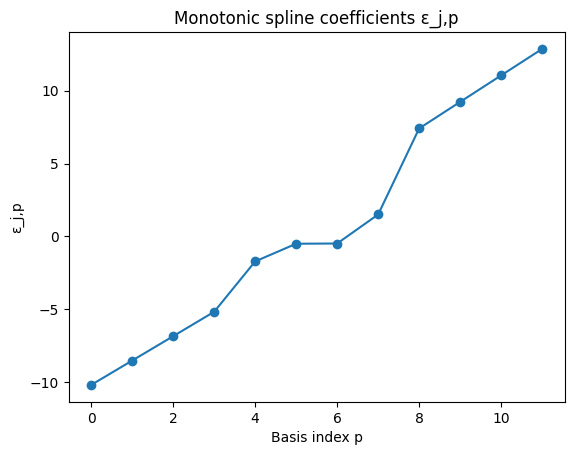

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.1332, -7.9470, -5.6896, -3.8919, -2.2421, -0.9876,  0.1171,  1.3631,
         2.3411,  3.2852,  4.2277,  5.1662])


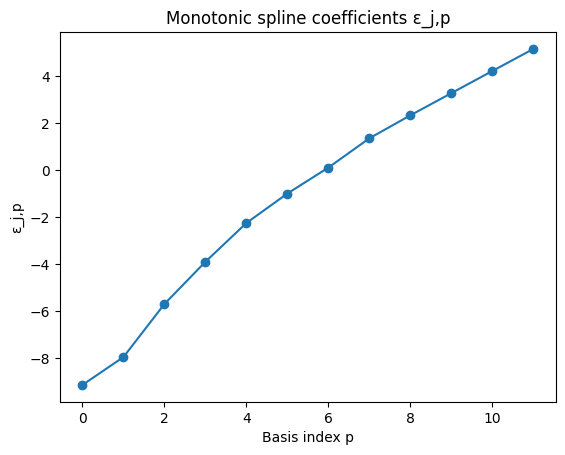

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9329, -8.1228, -6.3128, -4.5000, -2.8396, -0.1587,  0.4825,  4.7399,
         6.7222,  8.5404, 10.3585, 12.1767])


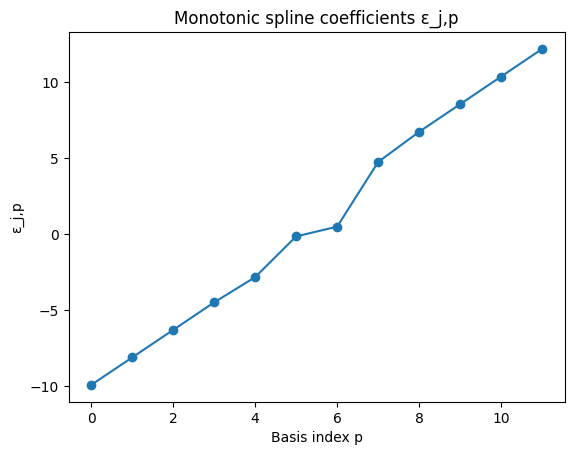

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.0898, -7.9690, -5.6027, -3.8397, -2.1915, -0.5303,  0.8377,  1.8958,
         2.8634,  3.8206,  4.7716,  5.7108])


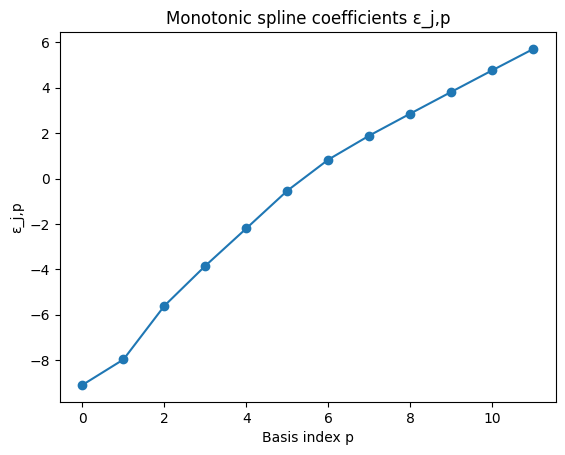

In [77]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

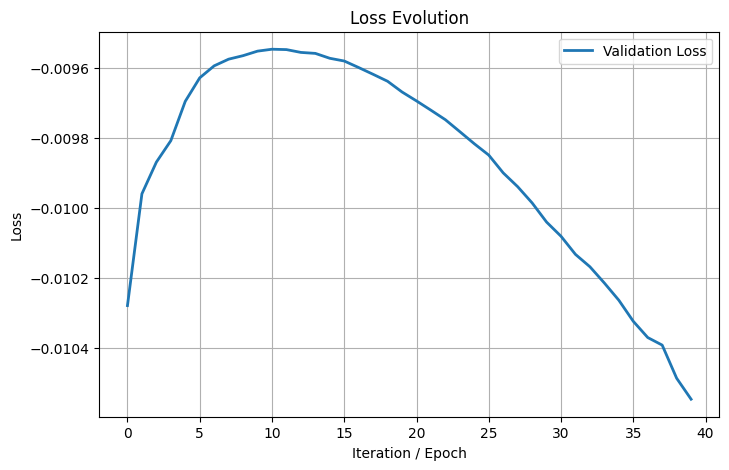

In [74]:
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [78]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [79]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.5824
KLD GTM      Train Data:  0.0841
KLD Gaussian Train Data:  -0.3439
KLD Copula   Train Data:  0.5271

KLD BGTM      Test  Data:  0.6024
KLD GTM      Test  Data:  0.0898
KLD Gaussian Test  Data:  -0.3079
KLD Copula   Test  Data:  0.5393


In [80]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

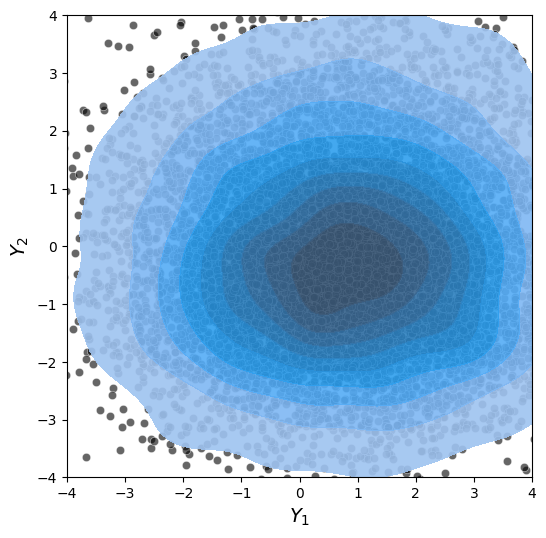

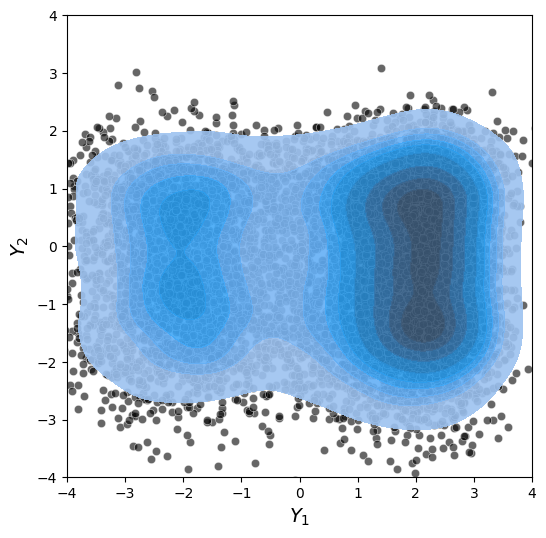

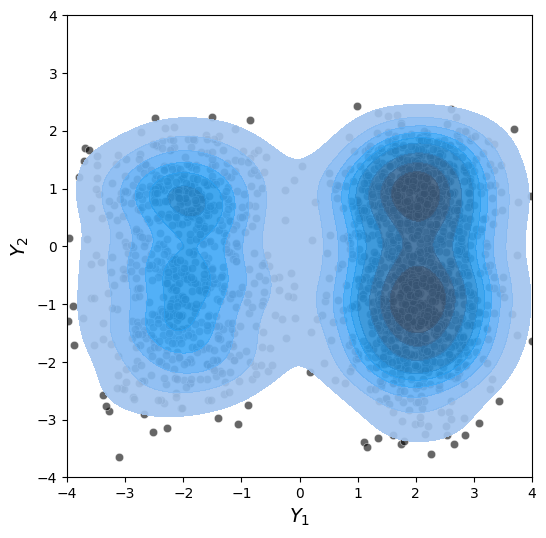

In [81]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])